<a href="https://colab.research.google.com/github/Cruiz118/Public_Procurement_Navarra_11_23/blob/main/TFM_Preprocesado_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Importamos los siguientes paquetes para la carga y tratamiento de datos
import os
import glob
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

# Importamos las librerías de análisis y visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

<a name="top"></a>
# 1. PRESENTACIÓN



<a name="item1.1"></a>
## 1.1 Motivación

La contratación pública es uno de los ejes estratégicos de cualquier Administración eficaz y eficiente. Su importancia es doble debido a dos características intrínsecas a cualquier proceso de licitación:

* Por un lado, las entidades públicas necesitan prestar una serie de servicios y realizar una serie de actuaciones para las que no está capacitada, por lo que deben acudir al mercado para poder cubrirlas.

* Por otro, estas prestaciones a contratar tienen una importancia cada vez mayor a nivel presupuestario, condicionando en gran medida las actuaciones que pueden llevar a cabo los entes públicos.

Diversos [informes](https://www.cnmc.es/ambitos-de-actuacion/promocion-de-la-competencia/contratacion-publica) de entidades independientes estiman que la contratación pública supera el 10% del PIB nacional , superando los 125 mil millones de [euros](https://www.administracionpublicadigital.es/proyectos/2024/02/el-gasto-publico-en-licitaciones-crece-un-17-en-2023-y-supera-los-125000-millones-de-euros.) En respuesta a esto, la comunidad científica actual está cada vez más interesada en aportar soluciones en esta área, con recientes investigaciones en el campo del Machine Learning que están dando prometedores resultados .


<a name="item1.2"></a>
## 1.2 Objetivo

El objetivo de este trabajo es crear un estimador de los precios de adjudicación de los contratos públicos de la Comunidad Foral de Navarra, herramienta que puede ayudar en la elaboración de presupuestos más exactos y realistas, así como coadyuvar al ahorro de las arcas públicas. Para este trabajo nos hemos basado en la investigación de [Manuel J. García Rodríguez](https://digibuo.uniovi.es/dspace/handle/10651/63675?show=full).

Nuestro trabajo consistirá en elaborar un modelo de regresión de los precios de adjudicación, es decir:

* Variable objetivo (y): será la variable _importe de adjudicación_.
* Variables predictoras (X): resto de variables de nuestro dataset.


<a name="item1.3"></a>
## 1.3 Glosario de términos

Dado que parte del vocabulario que vamos a utilizar es de contenido eminentemente jurídico, conviene tener claros algunos conceptos que van a utilizarse en nuestro análisis y posterior modelo.

Los principales son los siguientes:

1. **Adjudicador**: entidad pública encargada de iniciar, gestionar y finalizar el procedimiento de licitación. En términos más simples podemos entender que se trata del "contratante".
2. **Adjudicatario**: empresa o entidad a la que se adjudica y con la que se firma el contrato para la prestación de un servicio, el suministro de unos bienes o la realización de una obra.
Un mismo procedimiento puede tener varios adjudicatarios si este está dividido en distintos lotes.
Volviendo al lenguaje más coloquial, una vez firmado el contrato se trataría dle ente "contratado".
3. **Contrato**: documento jurídico en la que el/los adjudicadores acuerdan con el/los adjudicatarios la realización de una obra, prestación de un servicio o suministro de unos bienes a cambio de una contraprestación. Se trata del resultado final de todo el procedimiento de licitación.
4. **Importe de adjudicación**: importe por que el que finalmente se adjudica un contrato. Es el importe final por el que se ha llegado al acuerdo de realizar una determina obra, servicio o suministro.
4. **Licitación**: procedimiento que llevan a cabo las entidades públicas para cubrir sus necesidades. Estas necesidades pueden ser de tres tipos: realización de una obra, prestación de un servicio o suministro de unos bienes.
5. **Licitador**: empresa o ente que participa en el procedimiento de licitación. Realizan las ofertas por un precio determinar y posteriormente pueden o no ser aceptadas.
6. **Lote**: un mismo procedimiento puede tener distintos lotes. Esto dependerá si el objeto de contratación es susceptible de ser dividido.
Por ejemplo, una licitación para la contratatación de la limpieza viaria puede estar dividida en tres lotes distintos: _el primer lote_ trata de la contratación del personal encargado de la limpieza, el _segundo lote_ trata de la provisión y mantenimiento de la maquinaria y el _tercer lote_ puede consistir en la formación del personal en reciclaje y uso de productos sostenibles.
7. **Valor estimado** e **Importe de licitación**: Se trata del presupuesto o coste inicial que tiene establecida la entidad. En el Valor Estimado (VE) se tiene en cuenta la duración total del contrato cuando es superior a 1 año, mientras que en el Importe de licitación (IL) se considera únicamente la anualidad. Es decir, una licitación para la prestación de un servicio puede tener un IL de 100.000 euros pero un VE de 300.000 porque se va a contratar para 3 años. Esta distinción es importante ya que el **VE** es el que determina si se sigue un procedimiento más o menos riguroso y si tiene que publicarse a nivel europeo.




<a name="item2"></a>
# 2. PREPROCESADO DE DATOS

<a name="item2.1"></a>
## 2.1 Carga de datos

Los datos con los que vamos a trabajar son públicos y se encuentran disponibles para la ciudadanía a través del [Portal de Transparencia de Navarra](https://datosabiertos.navarra.es/es/dataset/registro-de-contratos).

Como puede observarse, se recogen los contratos licitados y adjudicados de todas las entidades públicas de la Comunidad Foral de Navarra. Desde Departamentos, Organismos Autónomos, Agencias... a los Ayuntamientos y sus entidades dependientes.

Entre las distintas modalidades de descarga, hemos escogido descargar los datos en formato CSV para su posterior manipulación y tratamiento.


In [27]:
#Damos acceso a los archivos de Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Lista de todos los archivos CSV en la carpeta
archivos_csv = glob.glob('/content/drive/MyDrive/TFM/Datos/CSV/*.csv')
# Lee y concatena los archivos de la carpeta en un solo DF
dataset = pd.concat([pd.read_csv(archivo, encoding= 'utf-8') for archivo in archivos_csv])
# Veamos nuestro dataset
print("El número de filas de nuestro dataset es de {}".format(len(dataset)))
print("El número de columnas de nuestro dataset es de {}".format(len(dataset.columns)))
print("Por tanto, el tamaño de nuestro dataset es de {}".format(dataset.size))

El número de filas de nuestro dataset es de 27667
El número de columnas de nuestro dataset es de 34
Por tanto, el tamaño de nuestro dataset es de 940678


Vemos que el dataset contiene un total de 27.667 filas y 34 columnas en las que se contiene la información relativa a las licitaciones llevadas a cabo en la Comunidad Foral de Navarra en los últimos 10 años.

Obtengamos un vistazo general de las filas y columnas de nuestra base de datos.

In [29]:
# Estructura general mediante la función head
# Ajustamos la salida para el resto del notebook
pd.options.display.max_columns = 30
pd.set_option('display.float_format', '{:.2f}'.format)
dataset.head()

,_id,Nombre del organismo contratante,Titulo,Modalidad,Tipo de contrato,Procedimiento,Criterio adjudicacion,Tramitacion,Valor estimado (Euros),Importe (Euros),Importe licitacion (Euros),Supuesto,Revision precios,Formula revision,Contrato plurianual,...,Lote,Adjudicatario,Fecha de adjudicacion,Fecha de formalizacion del contrato,Plazo o fecha fin,NIF,Importe adjudicacion (Euros),No de participantes,Clausulas sociales,Clausulas de compra ecologica,Contratacion de I+D,Contratacion de soluciones innovadoras,Importe financiacion (Euros),Reserva en licitacion,Importe Ejecutar (Euros)
0,1,Agencia Navarra para la Dependencia,Obras reforma parcial residencia Félix Echegaray,Contratos,Obras,Abierto,Mejor relación calidad-precio,Ordinaria,"480.950,36","363.598,47","418.217,70",NaN,N,NaN,NaN,...,NaN,"Erki Construcción Sostenible, SL",16/01/2023,NaN,6 meses,****1672*,"363.598,47",5.00,"Sociales: Adjudicación: 10,00 % de puntuación ...",N,N,N,"418.217,70",N,NaN
1,2,Agencia Navarra para la Dependencia,Acuerdo Marco para la selección de empresas qu...,Acuerdo marco,Suministro,Abierto,Mejor relación calidad-precio,Anticipada,"447.343,73",0,"447.343,73",NaN,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,"Sociales: Adjudicación: 10,00 % de puntuación ...",N,N,N,NaN,N,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Lote 1: Sociales: Adjudicación: 10,00 % de pun...",NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Lote 2: Sociales: Adjudicación: 10,00 % de pun...",NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Lote 3: Sociales: Adjudicación: 10,00 % de pun...",NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Columnas que componen nuestro dataset
dataset.columns

Index(['_id', 'Nombre del organismo contratante', 'Titulo', 'Modalidad',
       'Tipo de contrato', 'Procedimiento', 'Criterio adjudicacion',
       'Tramitacion', 'Valor estimado (Euros)', 'Importe (Euros)',
       'Importe licitacion (Euros)', 'Supuesto', 'Revision precios',
       'Formula revision', 'Contrato plurianual', 'Posibilidad de prorroga',
       'Plazo maximo', 'Codigos CPV', 'Varios Lotes', 'Lote', 'Adjudicatario',
       'Fecha de adjudicacion', 'Fecha de formalizacion del contrato',
       'Plazo o fecha fin', 'NIF', 'Importe adjudicacion (Euros)',
       'No de participantes', 'Clausulas sociales',
       'Clausulas de compra ecologica', 'Contratacion de I+D',
       'Contratacion de soluciones innovadoras',
       'Importe financiacion (Euros)', 'Reserva en licitacion',
       'Importe Ejecutar (Euros)'],
      dtype='object')

Dado que las columnas tienen nombres que posteriormente pueden darnos problemas a la hora de procesarlos, vamos a cambiarlos.

En lugar de utilizar técnicas de tratamiento de string, como no vamos a limitarnos a la conversión de minúsculas o eliminación de espacios vamos a hacerlo de forma más manual.

In [31]:
# Creamos un diccionario con los nombres antiguos y nuevos
nuevos_nombres = {
    '_id':'ID',
    'Nombre del organismo contratante':'adjudicador',
    'Titulo':'descripcion',
    'Modalidad':'modalidad',
    'Tipo de contrato':'tipo_contrato',
    'Procedimiento':'procedimiento',
    'Criterio adjudicacion':'criterio_adjudicacion',
    'Tramitacion':'tramitacion',
    'Valor estimado (Euros)':'valor_estimado',
    'Importe (Euros)':'importe_adj',
    'Importe licitacion (Euros)':'importe_estimado',
    'Supuesto':'proc_sin_concurrencia',
    'Revision precios':'rev_precios',
    'Formula revision':'form_rev',
    'Contrato plurianual':'plurianual',
    'Posibilidad de prorroga':'prorroga',
    'Plazo maximo':'plazo_max',
    'Codigos CPV':'cod_cpv',
    'Varios Lotes':'tiene_lote',
    'Lote':'texto_lote',
    'Adjudicatario':'adjudicatario',
    'Fecha de adjudicacion':'fecha_adjudicacion',
    'Fecha de formalizacion del contrato':'fecha_formalizacion',
    'Plazo o fecha fin':'duracion',
    'NIF':'nif',
    'Importe adjudicacion (Euros)':'importe_adj_lote',
    'No de participantes':'no_ofertas',
    'Clausulas sociales':'cl_social',
    'Clausulas de compra ecologica':'cl_ecolog',
    'Contratacion de I+D':'innov_des',
    'Contratacion de soluciones innovadoras':'sol_innov',
    'Importe financiacion (Euros)':'imp_financiacion',
    'Reserva en licitacion':'reserva_licitacion',
    'Importe Ejecutar (Euros)':'importe_ejecutar'
}

# Renombramos las columnas
dataset.rename(columns=nuevos_nombres, inplace=True)

In [32]:
# Info general
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27667 entries, 0 to 972
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     27667 non-null  int64  
 1   adjudicador            13606 non-null  object 
 2   descripcion            13606 non-null  object 
 3   modalidad              13606 non-null  object 
 4   tipo_contrato          13604 non-null  object 
 5   procedimiento          13604 non-null  object 
 6   criterio_adjudicacion  13578 non-null  object 
 7   tramitacion            13605 non-null  object 
 8   valor_estimado         13278 non-null  object 
 9   importe_adj            13605 non-null  object 
 10  importe_estimado       10491 non-null  object 
 11  proc_sin_concurrencia  3007 non-null   object 
 12  rev_precios            13606 non-null  object 
 13  form_rev               151 non-null    object 
 14  plurianual             1654 non-null   object 
 15  prorroga 

Ya en este primer vistazo podemos observar dos cuestiones fundamentales y que vamos a tener que solucionar:


*   Por un lado, que nuestro dataset está repleto **campos vacíos o sin datos (valores NaN)**.
*   Por otro, que **el formato** de varios de los campos es incorrecto. Existen columnas que debieran reconocerse como datos tipo float (importe de adjudicación, valor estimado, etc.) y otros float que en realidad debieran tener ser tipo text (código CSV).

Los apartado relativos al tratamiento y preprocesado de los datos van a ser fundamentales a la hora de conseguir un dataset completo y adecuado para nuestro propósito.


<a name="item2.1.1"></a>
### 2.1.1 Breve aclaración sobre la estructura de los datos

Cuando en un procedimiento de licitación existen varios [lotes](#item1.3) la forma en la que esto queda registrado es muy **problemática**.

Basicamente, en lugar de salir una única línea por cada licitación (que sería lo correcto) lo que se genera es una primera línea con gran parte de los datos que son generales de esa licitación (entidad adjudicataria, tipo de contrato, nº de participantes, etc.) y luego una serie de líneas que están practicamente vacías y que recogen información concreta de esos lotes en los que está dividida.

Un ejemplo sería el siguiente.

In [33]:
# Reseteamos el índice
dataset = dataset.reset_index(drop=True)

# Seleccionamos las filas y columnas vacías
dataset.iloc[0:8,0:20]

,ID,adjudicador,descripcion,modalidad,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,proc_sin_concurrencia,rev_precios,form_rev,plurianual,prorroga,plazo_max,cod_cpv,tiene_lote,texto_lote
0,1,Agencia Navarra para la Dependencia,Obras reforma parcial residencia Félix Echegaray,Contratos,Obras,Abierto,Mejor relación calidad-precio,Ordinaria,"480.950,36","363.598,47","418.217,70",NaN,N,NaN,NaN,N,NaN,45215000.00,N,NaN
1,2,Agencia Navarra para la Dependencia,Acuerdo Marco para la selección de empresas qu...,Acuerdo marco,Suministro,Abierto,Mejor relación calidad-precio,Anticipada,"447.343,73",0,"447.343,73",NaN,N,NaN,NaN,N,NaN,15000000.00,S,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En este ejemplo hemos cogido las primeras 8 líneas y columnas de nuestro dataset.

Como podemos ver, la primera línea muestra los datos de una licitación que no tiene ningún lote. En esta salen los datos completos y sin problema aparente  más allá de las transformaciones y procesamiento de datos que queramos realizar.

A partir de la segunda línea ya comienza a verse donde está el problema. En esta segunda línea sigue habiendo datos, que precisamente son los datos generales del procedimiento de licitación, pero encontramos varios campos vacíos (NaN). Estos campos vacíos son precisamente aquellos que se han visto afectados por la información introducida en cada lote.

Las siguientes 18 filas tienen un gran número de campos vacíos y solamente recogen información relativa a los lotes.

Hemos creado la siguiente función con la que hacernos a la idea del número de datos vacíos de nuestro dataset.

<Axes: >

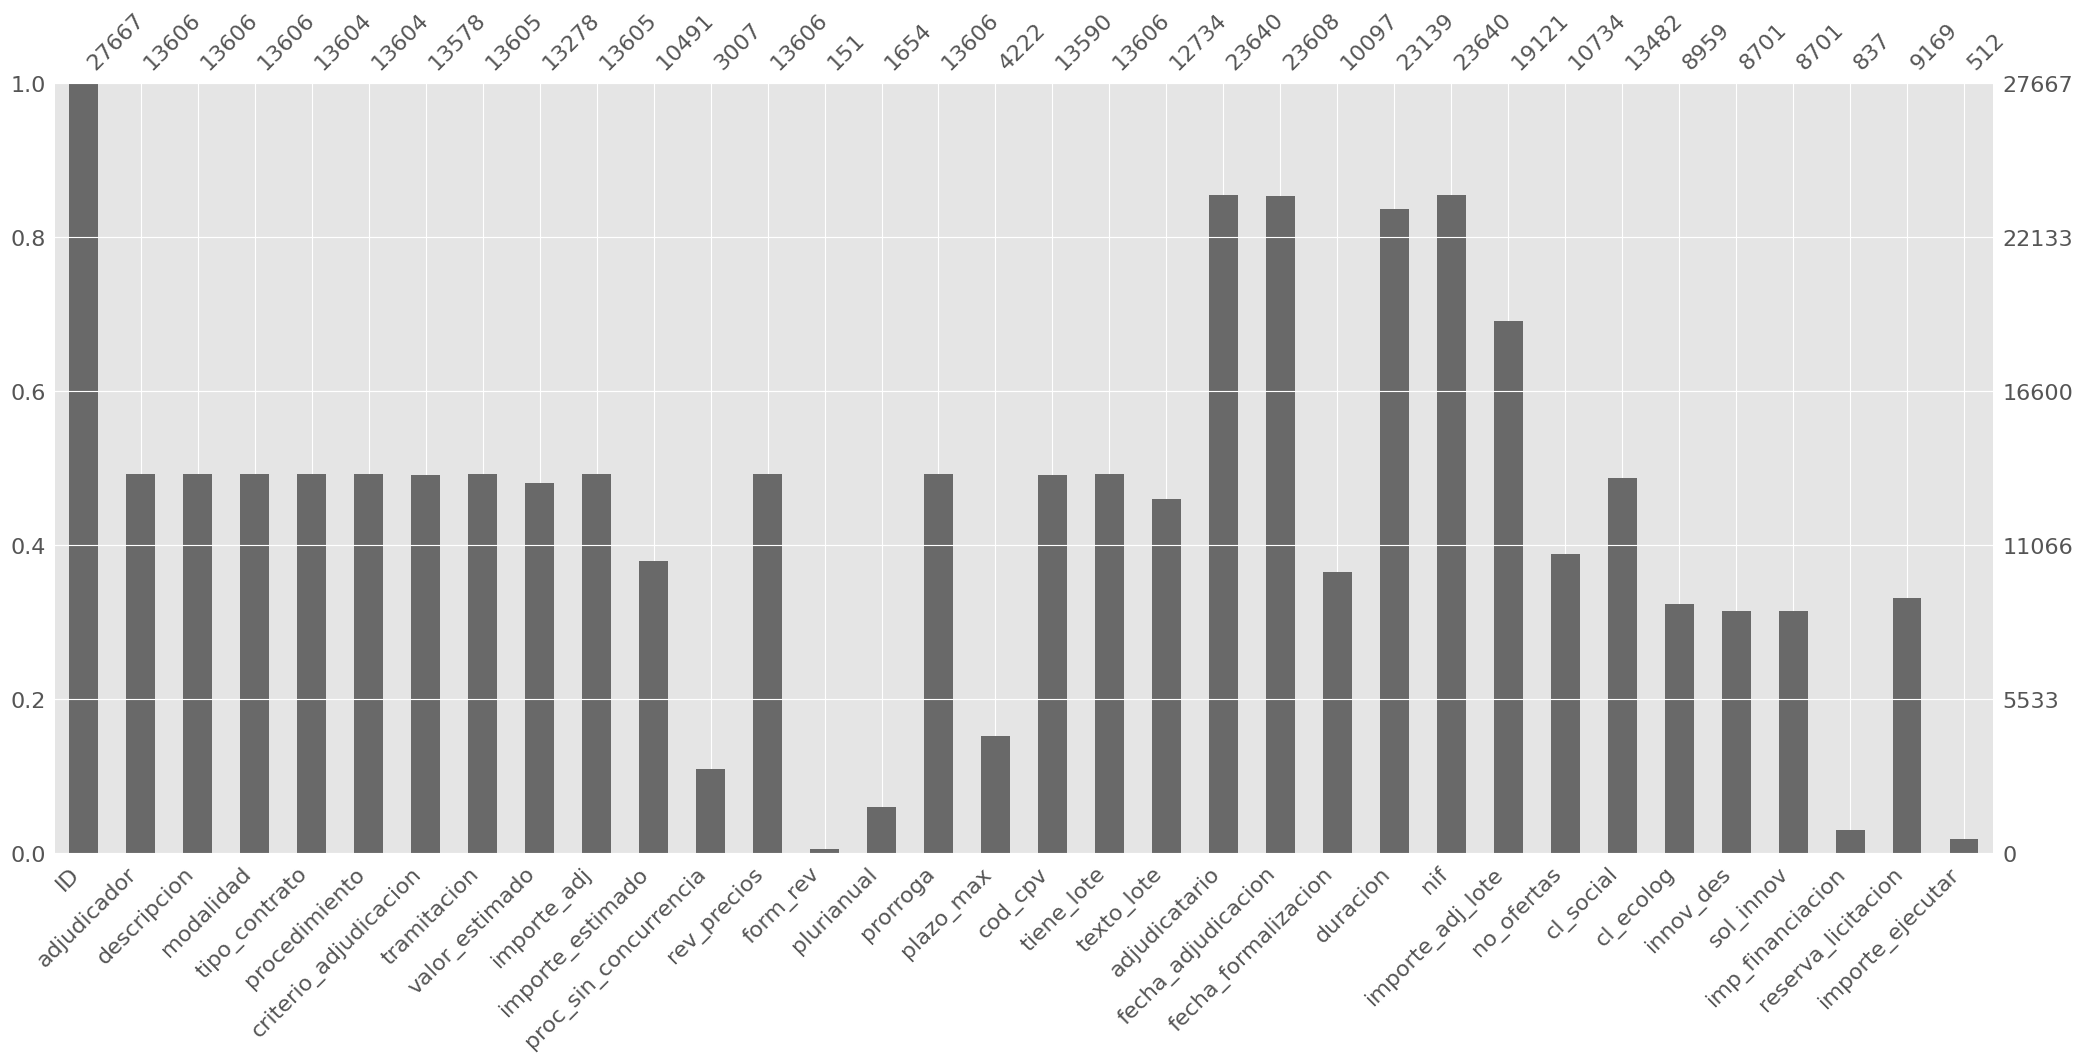

In [34]:
import missingno as msno
plt.figure(figsize=(10,8))
msno.bar(dataset)

In [35]:
def estado_df(df):
    # Creamos un diccionario para almacenar los resultados de cada campo
    resultados = {'nulos': [], 'completo': [], 'porcentaje': []}

    # Iteramos sobre las columnas del DataFrame
    for columna in df.columns:
        # Contamos los valores nulos (en blanco) en la columna
        nulos = df[columna].isnull().sum()
        # Contamos los valores no nulos (completos) en la columna
        completos = df[columna].notnull().sum()
        #Obtenemos el porcentaje
        porcentaje_nulos = round((nulos / len(df)) * 100,2)


        # Agregar los resultados al diccionario
        resultados['nulos'].append(nulos)
        resultados['completo'].append(completos)
        resultados['porcentaje'].append(porcentaje_nulos)

    # Crear un nuevo DataFrame a partir del diccionario
    df_completos = pd.DataFrame(resultados, index=df.columns)

    # Mostrar el DataFrame resultante
    print(df_completos) # Indent this line

In [36]:
estado_df(dataset)

                       nulos  completo  porcentaje
ID                         0     27667        0.00
adjudicador            14061     13606       50.82
descripcion            14061     13606       50.82
modalidad              14061     13606       50.82
tipo_contrato          14063     13604       50.83
procedimiento          14063     13604       50.83
criterio_adjudicacion  14089     13578       50.92
tramitacion            14062     13605       50.83
valor_estimado         14389     13278       52.01
importe_adj            14062     13605       50.83
importe_estimado       17176     10491       62.08
proc_sin_concurrencia  24660      3007       89.13
rev_precios            14061     13606       50.82
form_rev               27516       151       99.45
plurianual             26013      1654       94.02
prorroga               14061     13606       50.82
plazo_max              23445      4222       84.74
cod_cpv                14077     13590       50.88
tiene_lote             14061   

Como podemos observar, casi todas los columnas tienen más de un 50% de los campos vacíos.

Aunque a nivel de tratamiento de datos esto suponga problemas de preprocesado y normalización, esto es relativamente normal dado que la gran mayoría de los contratos se dividen en lotes (sobre todo desde que se modificó la normativa en 2017). Por lo tanto, es lógico que muchos de estos contratos contengan lotes distintos.

Planteado este problema nuestro objetivo de la etapa de preprocesamiento es claro: **obtener un dataset que integre en la medida de lo posible esta información y que finalmente tenga una línea por cada procedimiento de licitación**.

<a name="item2.2"></a>
## 2.2 Exploración y reducción de datos

El dataset contiene más de 30 columnas, muchas de las cuales contienen información potencialmente valiosa para nuestro análisis y que pueden influir sobre el precio final de adjudicación. Sin embargo, existen otras que por la mala calidad de los datos que contiene o su poca trascendencia pueden eliminarse.

El objetivo de este apartado es explicar el contenido de las columnas más relevantes de nuestro dataframe y determinar **cuáles de ellas vamos a utilizar en nuestro análisis y cuáles no**.


<a name="item2.2.1"></a>
### **Índice** (columna 0)


Se trata de una columna que originalmente debería contener un identificador único para cada una de las licitaciones.

Sin embargo, simplemente **contiene un conteo de las filas de nuestro DF**.

In [37]:
dataset['ID'].head(3)

,ID
0,1
1,2
2,3


Además, como podemos observar no es correlativo con el índice de nuestro DataFrame dado que estamos uniendo varios ficheros en uno solo (el último de los ficheros tiene solamente 973 filas, por eso aparece esa cifra).

Estos valores vienen determinados así de origen (no se trata de un error en la carga), por lo que no tienen valor alguno para nuestro análisis. Por ello **eliminaremos** esta columna y posteriormente crearemos un índice nuevo con el que realmente seamos capaces de distinguir cada contrato.

In [38]:
# Vamos a utilizar el método drop
dataset.drop(columns=['ID'], inplace=True)

<a name='item2.2.2'> </a>
### Adjudicador-Tramitación

Estas columnas contienen datos generales del ente contratante (adjudicador) y sobre el tipo de licitación que se está llevando a cabo.

In [39]:
dataset.columns[0:7]

Index(['adjudicador', 'descripcion', 'modalidad', 'tipo_contrato',
       'procedimiento', 'criterio_adjudicacion', 'tramitacion'],
      dtype='object')

Como hemos podido observar en el [apartado anterior](#item2.1.1) del total de filas solamente el 50% contienen datos.

En esta fase de preprocesado **tienen una gran importancia** dado que son las columnas que debemos utilizar para determinar si estamos ante un proceso de licitación distinto o no. Por tanto, __las utilizaremos para determinar cada línea de nuestro dataset__.

Exploremos de forma breve los datos que recoge cada una de estas columnas:

* **Adjudicador**

Contiene el nombre del ente que inicia, gestiona y finaliza el procedimiento de contratación.

Podemos encontrar Departamentos, Organismos Autónomas, Empresas Públicas, Ayuntamientos, etc.



In [40]:
#dataset['adjudicador'].unique()

In [41]:
len(dataset['adjudicador'].unique())

436

Tenemos un total de 436 entidades distintas.

El problema estriba en que algunas de ellas pueden estar **duplicadas**.

A lo largo de los 10 años que estamos analizando cada nuevo Gobierno tiene libertad para modificar la estructura orgánica de la Administración como estime conveniente. Estos cambios no son radicales y en su mayor parte la estructura permanece intacta, pero pueden existir ligeros cambios en los nombres de las entidades.


Con la siguiente función podemos ver que hay Departamentos como el de Hacienda o Presidencia que han ido modificándose con cada cambio de legislatura.

In [42]:
# Utilizamos la librería 're'
def buscar_palabra(df,palabra, columna):
# Buscamos cuántas veces sale la palabra que queramos
    escaped_palabra = re.escape(palabra) # Escaping the '(' to treat it as a literal character
    palabras_repetidas = df[columna][df[columna].str.contains(escaped_palabra, na=False)].unique()
    return palabras_repetidas

In [43]:
buscar_palabra(dataset,'Hacienda', 'adjudicador')

array(['Departamento de Economía y Hacienda',
       'Departamento de Hacienda y Política Financiera'], dtype=object)

Más adelante limpiaremos esta columna y la haremos apta para su análisis.

* **Modalidad**



El campo de modalidad recoge el tipo de procedimiento que se está llevando a cabo.

In [44]:
# Valores
dataset['modalidad'].unique()

array(['Contratos', 'Acuerdo marco', nan,
       'Sistema dinámico de adquisición',
       'Basado en un Sistema de Racionalización',
       'Anuncio de concurso de proyectos', 'Conciertos sociales',
       'Contratos Ley Foral 6/2006'], dtype=object)

In [45]:
# Número de valores
print(len(dataset['modalidad'].unique()))

8


En nuestro trabajo vamos a analizar solamente los procedimientos que dan lugar a un contrato con entes públicos (el resto son procedimientos especiales y cuyo tratamiento es diferente).

Por lo tanto, **nos quedaremos solamente con los que sean contratos**.

* **Tipo de contrato y Código CPV (Common Procuremente Vocabulary)**

En este campo se recoge el tipo de contrato que se está licitando.

Los datos incluyen dos tipos de identificadores:

*Tipo de contrato*: recoge la tipología genérica de la legislación española y que divide los contratos en tres tipos (sin incluir las concesiones): Obras, Servicios y Suministro.

In [46]:
# Tipos
dataset['tipo_contrato'].unique()

array(['Obras', 'Suministro', nan, 'Servicios', 'Concesión de servicios',
       'Concesión de obra pública', 'Asistencia'], dtype=object)

In [47]:
# Número de valores
print(len(dataset['tipo_contrato'].unique()))

7


*Código CPV (Common Procurement Vocabulary)*: se trata del código identificativo del tipo de contrato a nivel europeo (establecido por la UE). Contiene un mayor nivel de detalle y puede ser útil en nuestro análisis.

In [48]:
# Tipos
dataset['cod_cpv'].unique()

array([45215000., 15000000.,       nan, ..., 45247000., 64216200.,
       50344100.])

In [49]:
print(len(dataset['cod_cpv'].unique()))

1648


Como podemos ver la variedad en este segundo caso es mucho mayor.

Lo veremos más adelante, pero merece la pena recalcar que los dos primeros dígitos de este código determinan el **sector** al que pertenece este contrato. Aporta un mayor nivel de detalle que la columna "tipo_contrato" y puede servirnos para clasificar de forma más racional la multitud de licitaciones que estamos analizando.

* **Procedimiento**

Existen diversos tipos de procedimientos.

In [50]:
dataset['procedimiento'].unique()

array(['Abierto', nan, 'Procedimiento simplificado', 'Restringido',
       'Negociado sin convocatoria de licitación',
       'Basado en un acuerdo marco', 'Negociado', 'Sin procedimiento',
       'Basado en un sistema dinámico de adquisición',
       'Concurso de proyectos', 'Negociado sin publicidad comunitaria',
       'Diálogo competitivo', 'Negociado con publicidad comunitaria',
       'Contrato derivado de acuerdo marco'], dtype=object)

In [51]:
print(len(dataset['procedimiento'].unique()))

14


Los entes públicos deben utilizar uno u otro dependiendo del **valor estimado** del contrato que estén licitando y de la casuística concreta del objeto.

La distinción entre cada uno de ellos es relevante dado que dependiendo del procedimiento que se siga dará lugar a:

* Mayor publicidad.
* Por ende, una mayor probabilidad de concurrencia de licitadores.

Según la teoría económica elemental, a mayor competencia menores precios (como norma general), por lo que podemos esperar que en procedimientos de mayor publicidad acudan más licitadores y que esto haga que caiga el precio final de adjudicación.

* **Criterio de adjudicación**

Este campo recoge los distintos criterios que ha determinado el adjudicador para decidir con qué licitador ha de contratar.

In [52]:
dataset['criterio_adjudicacion'].unique()

array(['Mejor relación calidad-precio', nan,
       'Mejor relación coste-eficacia: precio',
       'Mejor relación calidad y coste-eficacia', 'Oferta más ventajosa',
       'Mejor relación coste-eficacia: otro',
       'Mejor relación coste-eficacia: coste del ciclo de vida',
       'Precio más bajo'], dtype=object)

In [53]:
print(len(dataset['criterio_adjudicacion'].unique()))

8


Más adelante veremos si estas distinciones pueden agruparse a un mayor nivel y así homogeneizar los criterios.

* **Tramitación**

El tipo de tramitación es de los siguientes tipos:

In [54]:
dataset['tramitacion'].unique()

array(['Ordinaria', 'Anticipada', nan, 'Emergencia', 'Ordenaria',
       'Urgente'], dtype=object)

In [55]:
print(len(dataset['tramitacion'].unique()))

6


¿Qué significan cada uno de estos tipos de tramitación?

La tramitación **ordinaria** es la que la normativa contempla que generalmente debe ser usada. Implica una serie de plazos y trámites que siempre deben cumplirse así como mecanismos de control estrictos.



Por último, encontramos la tramitación **urgente/emergencia**. Estos se utilizan *"cuando la Administración tenga que actuar de manera inmediata a causa de acontecimientos catastróficos, de situaciones que supongan grave peligro o de necesidades que afecten a la seguridad pública"*. Es por ejemplo la tramitación que su utilizó durante la crisis del Covid. Supone un procedimiento más laxo en el que prima la celeridad, por lo que este tipo de licitaciones carecen de sistemas de control preventivos y, normalmente, hay una menor concurrencia de licitadores.

Ya en este apartado observamos que existen errores en el registro de los datos (seguramente por haberse introducido a mano) que deberemos corregir.

* **Descripción**

Se trata de un campo de texto libre donde el gestor encargado de introducir los datos escribe un breve resumen del procedimiento o simplemente su título.

La información aquí contenida parece muy heterogénea y difícilmente explotable, por lo que prescindiremos de la misma.

In [56]:
# Utilizamos el método drop
dataset.drop(columns=['descripcion'], inplace=True)
# Resultado
dataset.columns

Index(['adjudicador', 'modalidad', 'tipo_contrato', 'procedimiento',
       'criterio_adjudicacion', 'tramitacion', 'valor_estimado', 'importe_adj',
       'importe_estimado', 'proc_sin_concurrencia', 'rev_precios', 'form_rev',
       'plurianual', 'prorroga', 'plazo_max', 'cod_cpv', 'tiene_lote',
       'texto_lote', 'adjudicatario', 'fecha_adjudicacion',
       'fecha_formalizacion', 'duracion', 'nif', 'importe_adj_lote',
       'no_ofertas', 'cl_social', 'cl_ecolog', 'innov_des', 'sol_innov',
       'imp_financiacion', 'reserva_licitacion', 'importe_ejecutar'],
      dtype='object')

<a name='index2.2.3'> </a>
### Importes


El dataset contiene información numérica sobre los presupuestos de licitación (valor e importe estimado) y los precios de adjudicación.

In [57]:
dataset[['valor_estimado','importe_adj', 'importe_estimado','importe_adj_lote']].head(3)

,valor_estimado,importe_adj,importe_estimado,importe_adj_lote
0,"480.950,36","363.598,47","418.217,70","363.598,47"
1,"447.343,73",0,"447.343,73",NaN
2,NaN,NaN,NaN,NaN


Se trata de campos **importantes** dado que es sobre los que trabajaremos nuestro modelo.

Los hemos descrito brevemente en la introducción, pero puntualicémoslo un poco más:

* __Valor estimado__: se trata del presupuesto inicial estimado por el ente adjudicador (contratante). Tiene en cuenta la duración del contrato, de forma que si un contrato está previsto que dure 4 años esto afectará a su valor estimado.

* __Importe estimado__: Se trata del presupuesto _anual_ que el adjudicatario estima va a costar el contrato, esto es la anualidad. Cuando el contrato tiene una duración inferior o igual al año este campo y el valor estimado tienen el mismo valor.

* __Importe de adjudicación__: se trata del importe por el que ha sido adjudicado finalmente el contrato, es decir, por el que se ha comprometido a realizarlo el adjudicatario (contratista).
La diferencia entre el valor estimado y el importe de adjudicación es lo que el contratante se supone está __"ahorrándose"__ respecto al presupuesto inicial.
Esta va a ser nuestra **variable objetivo (Y)**.


* __Importe adjudicación lote__: Este campo se utiliza para introducir el valor por el que se ha adjudicado un lote concreto y el coste final de una anualidad respecto al importe estimado por el ente público.

Para nuestro modelo vamos a trabajar solamente con cifras agregadas, ya que son las únicas comparables con el presupuesto inicial (valor estimado). Las tres priemras columnas ya nos aportan esta información. De hecho, el *importe de adjudicación* es una agrupación del *importe adjudicación por lote*.

Por lo tanto, vamos a **eliminar** esta última columna y trabajar con las demás.


In [58]:
# Utilizamos el método drop
dataset.drop(columns='importe_adj_lote', inplace = True)

También existen diversos campos relativos a la revisión de precios, tales como:

In [59]:
dataset[['rev_precios','form_rev']].head(5)

,rev_precios,form_rev
0,N,NaN
1,N,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


El campo _"revisión de precios"_ es de tipo binario (S/N) y simplemente determina si los precios del contrato son susceptibles de una posterior revisión.

El campo _"forma de revisión"_ es un campo de texto libre y heterógeneo donde, de forma opcional, se encuentra descrita la fórmula de revisión de precios.

Al tratarse de un campo difícilmente explotable prescindiremos de él.

In [60]:
# Método drop
dataset.drop(columns=['form_rev'], inplace=True)

<a name='item2.2.4'> </a>
### Campos de fecha

Contamos con varios campos con formato fecha (o que debieran tenerlo) y que pueden ser útiles para nuestro análisis. Describámoslos brevemente:

Existen dos campos que contiene datos de tipo binario (S/N):

* **Prórroga**: determina si un contrato es susceptible de prórrogas.
* **Plurianual**: determina si un contrato tiene una duración superior al año.

In [61]:
# Campos con datos binarios
dataset[['plurianual', 'prorroga']].values

array([[nan, 'N'],
       [nan, 'N'],
       [nan, nan],
       ...,
       [nan, 'S'],
       [nan, 'S'],
       [nan, nan]], dtype=object)

Otros tienen el formato de tipo fecha (que habrá que ajustarlo más adelante):
* **Fecha de adjudicación**: recoge la fecha en la que el contrato ha sido adjudicado.
* **Fecha de formalización**: recoge la fecha en la que se ha formalizado el contrato.


Por último, tenemos dos campos con información temporal muy relevante pero cuyo tratamiento es necesario dada la heterogeneidad de los datos que contienen:

* **Plazo máximo**: recoge el plazo máximo de duración que pueden tener un contrato .
* **Duración**: duración estimada de un contrato.

Estos dos campos están relacionados, ya que la duración de los contratos suele prolongarse hasta su fecha máxima de duración (debido a lo costosa que es su licitación).

Ambos campos contienen información similar, con el matiz de que en la duración suele recogerse una estimación para el año.

In [62]:
# Veamos la información de ambos campos al mismo tiempo
durac_plazo = dataset[['plazo_max', 'duracion']]
durac_plazo.dropna(how='all', inplace=True)
durac_plazo.head(5)

,plazo_max,duracion
0,NaN,6 meses
9,NaN,14/02/2023 - 31/12/2023
10,NaN,14/02/2023 - 31/12/2023
11,NaN,14/02/2023 - 31/12/2023
12,NaN,14/02/2023 - 31/12/2023


Como puede obsevarse se trata de dos campos con datos en distinto formato y que requerirán de un trabajo de procesado y homogeinización.

<a name='item2.2.5'> </a>
### Otros campos relevantes

De entre el resto de campos encontramos especialmente relevantes los siguientes:
* **Tiene lote**: se trata de un campo de tipo binario (S/N) que determina si en un procedimiento hay varios lotes o no.
* **NIF**: Identificador del adjudicatario al que se le ha adjudicado el lote.
* **Número de ofertas**: recoge el número de licitadores/ofertas que se han presentado a ese procedimiento.


<a name='index2.2.6'> </a>
### Campos con menor relevancia


Existen una serie de campos que no resultan tan relevantes para nuestro análisis:
* **Texto lote**: no es un campo relevante a nivel analítico (debido a su heterogeneidad y difícil tratamiento) pero en el apartado siguiente lo utilizaremos para lograr un dataset estructurado.

* **Adjudicatario**: nombre del adjudicatario al que se le ha adjudicado el contrato. Es un campo de texto manual con gran heterogeneidad y difícil tratamiento. Esto conlleva a que una misma empresa esté escrita de muy distintas formas. Es preferible la utilización del siguiente.


In [63]:
# Insertamos la palabra de la empresa que queremos buscar
empresa = 'OSES'

# Aplicamos la función a la columna 'adjudicatario'
nombres_empresas = dataset[dataset['adjudicatario'].str.contains(empresa, na =False)]\
 ['adjudicatario'].unique().tolist()

conteo_empresas = dataset[dataset['adjudicatario'].isin(nombres_empresas)]\
 ['adjudicatario'].value_counts().reset_index()

# Mostramos los resultados
print('La empresa {} aparece de {} formas distintas, que son las siguiente \n {}'.\
      format(empresa, len(conteo_empresas),nombres_empresas))

La empresa OSES aparece de 30 formas distintas, que son las siguiente 
 ['EXCAVACIONES FERMIN OSES, SL', 'EXCAVACIONES FERMIN OSES S.L.', 'EXCAVACIONES FERMIN OSES SL', 'ACCIONA CONSTRUCCIÓN SA / EXCAVACIONES FERMÍN OSES SL / SERVINABAR 2000 SL', 'EXCAVACIONES FERMÍN OSES, S.L.', 'EXCAVACIONES FERMIN OSES S.L', 'EXCAVACIONES FERMÍN OSES, S.L', 'UTE SALUD UPNA_EXCAVACIONES FERMIN OSES S.L.-CONSTRUCCIONES MARIEZCURRENA S.L.', 'EXCAV FERMIN OSES S.L.', 'EXCAVACIONES FERMIN OSES, S.L.', 'JOSE JAVIER OSES PEREZ-MUNIAIN', 'MARI CRUZ BASARTE OSES', 'J.JAVIER ASIAIN-PABLO FLORES-J.JAVIER OSES', 'UTE GIMA-OSES NUEVAS SALAS DE HEMODINAMICA EN EL EDIFICIO DE URGENCIAS DEL HUN', 'OSES', 'EXCAVACIONES FERMIN OSES', 'EXCAVACIONES FERMIN OSES,S.L.', 'MIGUEL OSES MURUZABAL', 'UTE GIMA-OSES URGENCIAS CHN', 'EXCAVACIONES FERMIN OSES, S.L', 'EXCAVACIONES FERMÍN OSES S.L.', 'EXCAVACION3ES FERMIN OSES S.L.', 'OSÉS CONSTRUCCIÓN, EXCAVACIONES FERMÍN OSES.S.L', 'EXCAVACIONES FERMIN OSES, S.L.-SANPO OBRAS ESPE

Ambos son datos que en otros modelos de aprendizaje (sobre todo para detección de fraude) pueden ser muy relevantes.

Sin embargo, en nuestro caso no lo son tanto y por ello prescindiremos de los mismos.

* **Procedimientos sin concurrencia**: Se trata de un campo donde se recoge el artículo de la ley por el que se han aplicado procedimientos de menor concurrencia.
Esa información ya la tenemos en el campo "procedimiento" y por lo tanto prescindiremos de esta columna.

* **Últimas 7 columnas (cláusulas sociales a importe a ejecutar)**: son columnas que se incorporaron a partir de 2018 y que en años anteriores no existían. La mayor parte de ellos tienen datos de tipo binario (S/N), indicando si el contrato incorpora determinadas cláusulas o no. Vamos a eliminarlos de forma provisional y veremos si más adelante los utilizamos.

In [64]:
# Eliminamos con drop
dataset.drop(columns=['adjudicatario','proc_sin_concurrencia','cl_social', 'cl_ecolog', 'innov_des', 'sol_innov', 'imp_financiacion', 'reserva_licitacion', 'importe_ejecutar'], inplace=True)
# Resultado
dataset.columns

Index(['adjudicador', 'modalidad', 'tipo_contrato', 'procedimiento',
       'criterio_adjudicacion', 'tramitacion', 'valor_estimado', 'importe_adj',
       'importe_estimado', 'rev_precios', 'plurianual', 'prorroga',
       'plazo_max', 'cod_cpv', 'tiene_lote', 'texto_lote',
       'fecha_adjudicacion', 'fecha_formalizacion', 'duracion', 'nif',
       'no_ofertas'],
      dtype='object')

<a name='index2.2.7'> </a>
### Resultado

Tras este apartado hemos eliminado aproximadamente 10 columnas. El dataset queda de la siguiente forma:

In [65]:
dataset.shape

(27667, 21)

Hecho esto podemos realizar un **primer filtrado** de los datos, eliminando todas aquellas filas que tenga campos vacíos (NaN).

In [66]:
# Filtramos utilizando una condición
df = dataset.dropna(how='all')
df.shape

(25791, 21)

Vemos como en este punto el dataset original se ha reducido considerablemente.

In [67]:
print("El número de filas de nuestro dataset es de {}".format(len(df)))
print("El número de columnas de nuestro dataset es de {}".format(len(df.columns)))
print("Por tanto, el tamaño de nuestro dataset es de {}".format(df.size))

El número de filas de nuestro dataset es de 25791
El número de columnas de nuestro dataset es de 21
Por tanto, el tamaño de nuestro dataset es de 541611


<a name = 'item2.3'></a>
## 2.3 Limpieza de datos

Anteriormente hemos comentado que existen algunas columnas cuyo tipo de dato no ha sido correctamente identificado en la carga.

Esto se debe a que en gran parte de los datos son incorporados de forma manual e incorporan una serie de caracteres, espacios o tipo de puntuación que afecta a su reconocimiento automático.

Asimismo, a la hora de homogeneizar y trabajar con campos de tipo texto es recomendable realizar cierto trabajo de limpieza sobre los mismos (eliminación de espacios, caracteres especiales, etc.).

En este apartado vamos a tratar de lograr un df con una tipología de datos bien definida y con los campos medianamente preparados para su procesamiento posterior.

<a name='item2.3.1'> </a>
### 2.3.1 Cambio de tipo de datos numéricos

Comenzamos por corregir las columnas que debieran ser de **tipo numérico**.

In [68]:
# Función para converir a float
# ==============================================================================
def convertir_float(valor):
  # Comprobamos en primer lugar si el campo es float
  if isinstance(valor, float):
    return valor
  # Eliminamos los puntos y posteriormente las comas
  # Manejamos posibles errores de valor
  try:
    # Control adicional
    if isinstance(valor, str):
        valor = valor.replace('.', '').replace(',', '.')
    return float(valor)
  except:
    return float('nan')

# Aplicamos la función a las columnas correspondientes
df['valor_estimado'] = df['valor_estimado'].apply(convertir_float)
df['importe_adj'] = df['importe_adj'].apply(convertir_float)
df['importe_estimado'] = df['importe_estimado'].apply(convertir_float)

<a name='item2.3.2'></a>
### 2.3.2 Cambio de tipo de dato fecha

En este apartado vamos a tratar los campos:
* Fecha adjudicación.
* Fecha formalización.

Los campos "plazo máximo" y "duración" requieren de transformaciones más profundas, por lo que serán analizadas y modificadas en apartados posteriores.

In [69]:
# Función para formato fecha
# ==============================================================================
def todate(fecha):
  if fecha is not None:
    # Incluimos todos los formatos existentes en el dataset
    formats = ['%d/%m/%Y', '%Y-%m-%d', '%Y-%m-%d %H:%M:%S']
    for fmt in formats:
      try:
        return pd.to_datetime(fecha, format=fmt)
      except ValueError:
        pass
    return pd.NaT
  else:
    return None

In [70]:
df['fecha_adjudicacion'] = df['fecha_adjudicacion'].apply(todate)
df['fecha_formalizacion'] = df['fecha_formalizacion'].apply(todate)

<a name='item2.3.3'></a>
### 2.3.3 Cambio de tipo de dato texto

Vamos a realizar una serie de modificaciones básicas sobre las columnas de tipo texto, de forma que nos quedemos solamente con las palabras relevantes y sea más sencilla su utilización posterior.

Vamos a utilizar una función en la que convertiremos las columnas a texto y las pasaremos a minúsculas.

Asimismo, vamos a aplicar esta función sobre la columna "Cod_CPV", ya que realmente no estamos ante un campo numérico sino ante un código identificativo del tipo de contrato.

In [71]:
# Función más sencilla para el tratamiento de las celdas de texto
# ==============================================================================
# Convertimos las columnas object a string
def to_string(texto):
  'Convertimos las columnas correspondientes a string'
  if isinstance(texto, str):
    return texto
  else:
    return str(texto)

# Función general
def limpieza_text(text):
  res = to_string(text)
  res = res.lower()
  return res


In [72]:
# Aplicamos a las columnas que van a ser modificadas
df['adjudicador'] = df['adjudicador'].apply(limpieza_text)
df['modalidad'] = df['modalidad'].apply(limpieza_text)
df['tipo_contrato'] = df['tipo_contrato'].apply(limpieza_text)
df['procedimiento'] = df['procedimiento'].apply(limpieza_text)
df['criterio_adjudicacion']= df['criterio_adjudicacion'].apply(limpieza_text)
df['tramitacion'] = df['tramitacion'].apply(limpieza_text)
df['cod_cpv'] = df['cod_cpv'].apply(limpieza_text)

Posteriormente realizaremos modificaciones más profundas sobre estas columnas.

<a name = 'item2.4'></a>
## 2.4 Transformaciones sobre el dataset I

El problema planteado en el [apartado anterior](#item2.1.1) es **fundamental** solucionarlo con anterioridad a cualquier análisis que queramos hacer, ya que el elevado número de campos vacíos y datos dispersos va a condicionar todo nuestro análisis.

Así pues, en primer lugar vamos a realizar una serie de **transformaciones** para obtener un dataset íntegro y con el que pueda trabajarse, limitando en la medida de los posible la pérdida de información.

El objetivo de este apartado es lograr lo siguiente:

1. Obtener un ID único de cada contrato.
2. Obtener una columna donde quede registrado el número de lotes de cada licitación.
3. Obtener una columna con el número de adjudicatarios distintos.
4. Finalmente, obtener un dataframe con una fila por licitación.

<a name='item2.4.1'> </a>
### 2.4.1 Creación de un identificador único de contratos

Vamos a empezar por crear un identificador único para cada contrato.

Para ello, vamos a seguir los siguientes criterios:
* El cambio de licitación se da cada vez que las columnas adjudicatario a tramitación contienen datos (estos campos no pueden estar vacíos). Es decir, las columnas 0:7.
* Ese identificador será el mismo hasta que en los campos mencionadas vuelva a aparecer algún valor.

In [73]:
# Función para la creación de la columna 'Id_contrato'
# ==============================================================================
# Creamos la columna 'id_contrato' con valores nulos
df['id_contrato'] = None

# Creamos una función para generar el identificador único
def identificador(row, dataset):
    """Genera un identificador único para cada contrato."""
    # Convertimos todos los valores a string para concatenarlos
    id = str(row['adjudicador']) +'-'+ str(row['modalidad']) +'-'+ str(row['tipo_contrato']) + '-'+ \
         str(row['procedimiento']) +'-'+str(row['criterio_adjudicacion']) +'-'+ str(row['tramitacion'])+'-'+\
         str(row['valor_estimado'])+'-'+str(row['cod_cpv'])+'-'+str(row['fecha_adjudicacion'])
    if row['adjudicador']!='nan' and row['tramitacion']!='nan':
        return id
    else:
        None

# Aplicamos la función, pasando el DataFrame como argumento adicional
df['id_contrato'] = df.apply(identificador, axis=1, args=(df,))

In [74]:
# Rellenamos los campos vacíos con el identificador recientemente creado
df['id_contrato'].fillna(method='ffill', inplace=True)

Vemos que no hay campos vacíos en la nueva columna.

In [75]:
# Filtramos
df[df['id_contrato'].isnull()]

,adjudicador,modalidad,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,plazo_max,cod_cpv,tiene_lote,texto_lote,fecha_adjudicacion,fecha_formalizacion,duracion,nif,no_ofertas,id_contrato


<a name='item2.4.2'> </a>
### 2.4.2 Exploración datos vacíos

Como hemos comentado, **los campos de adjudicación a tramitación son los que vamos a utilizar como base para crear nuestras filas únicas con datos de la licitación**.

La idea es, sobre los mismos, incorporar toda la información que está dispersa en filas mayormente vacías de datos.

Veamos qué información debemos incorporar.

In [76]:
# Las filas con información de los lotes son en las que no hay datos de la columna 0:7
dataset_blanco = df[df['adjudicador']=='nan']
dataset_blanco.head(3)

,adjudicador,modalidad,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,plazo_max,cod_cpv,tiene_lote,texto_lote,fecha_adjudicacion,fecha_formalizacion,duracion,nif,no_ofertas,id_contrato
9,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,Lote 9 Frutas y Verduras Enero- Febrero: 15300000,2023-02-02,2023-02-14,14/02/2023 - 31/12/2023,****1959*,NaN,agencia navarra para la dependencia-acuerdo ma...
10,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,Lote 9 Frutas y Verduras Enero- Febrero: 15300000,2023-02-02,2023-02-14,14/02/2023 - 31/12/2023,****1563*,NaN,agencia navarra para la dependencia-acuerdo ma...
11,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,Lote 10 Frutas y Verduras Marzo- Abril: 15300000,2023-02-02,2023-02-14,14/02/2023 - 31/12/2023,****1959*,NaN,agencia navarra para la dependencia-acuerdo ma...


Vamos a utilizar la función creada anteriormente con la que sabremos que información debemos incorporar a nuestro dataset

In [77]:
estado_df(dataset_blanco)

                       nulos  completo  porcentaje
adjudicador                0     12185        0.00
modalidad                  0     12185        0.00
tipo_contrato              0     12185        0.00
procedimiento              0     12185        0.00
criterio_adjudicacion      0     12185        0.00
tramitacion                0     12185        0.00
valor_estimado         12185         0      100.00
importe_adj            12185         0      100.00
importe_estimado       12185         0      100.00
rev_precios            12185         0      100.00
plurianual             12185         0      100.00
prorroga               12185         0      100.00
plazo_max              12185         0      100.00
cod_cpv                    0     12185        0.00
tiene_lote             12185         0      100.00
texto_lote              1282     10903       10.52
fecha_adjudicacion      2120     10065       17.40
fecha_formalizacion     8824      3361       72.42
duracion                2582   

La información a incorporar viene de las siguientes columnas:
* texto_lote: realizaremos un conteo de las filas y lo transformaremos en una nueva columna del df original denominada "no_de_lotes".
* fecha de adjudicación: consideraremos que la fecha de adjudicación ha sido la misma para todos los lotes (sabemos que por normativa es así).
* fecha de formalización: consideraremos que la fecha de formalización ha sido la misma para todos los lotes (sabemos que por normativa es así).
* duración: consideraremos que la duración es la misma para todos los lotes.
* importe de adjudicación del lote: crearemos una nueva columna de "importe_adj_total", que será el sumatorio de todos los importes. Para ello, previamente tenemos que convertir la columna a tipo float.


<a name='item2.4.3'> </a>
### 2.4.3 Creación de las funciones y transformación

* **Número de lotes**

Vamos a comenzar creando una función que **cuente el número de lotes de cada procedimiento**.

Para ello, vamos a "contar" el número de filas del campo "texto_lote" que no esté vacío.

In [78]:
# Función para contar el número de lotes de una licitación
# ==============================================================================
def cuenta_lotes(df):
    """Cuenta el número de lotes de cada procedimiento."""
    # Creamos una nueva columna "no_de_lotes"
    df['no_de_lotes_fe'] = 1  # Valor por defecto si "adjudicador" no es nulo

    # Agrupamos el df por "id_contrato" si hay valores nulos en "adjudicador"
    if (df['tiene_lote']=='S').any():
        for id_contrato, grupo in df.groupby('id_contrato'):
            # Cuenta las filas con valor en el campo "texto_lote"
            num_lotes = grupo['texto_lote'].notnull().sum()

            # Asigna el número de lotes a TODAS las filas con el mismo "id_contrato"
            df.loc[df['id_contrato'] == id_contrato, 'no_de_lotes_fe'] = num_lotes
    else:
        df['no_de_lotes_fe'] = 1

    return df  # Devuelve el DataFrame modificado #Fixed indentation here

# Aplica la función al DataFrame original
df = cuenta_lotes(df)

In [79]:
# Vamos a susituir los 0 por 1
df['no_de_lotes_fe'] = df['no_de_lotes_fe'].replace(0, 1)

* **Número de adjudicatarios**

A continuación, vamos a calcular **a cuántos adjudicatarios distintos se les ha asignado un lote**. Es decir, cuántos contratistas existen al final del procedimiento de licitación.

In [80]:
# Función para contar el número de adjudicatarios de una licitación
# ==============================================================================
def cuenta_adj(df):
  'Contamos los NIF distintos de las filas de lotes'
  # Comenzamos por crear la columna sobre la que generar nuestro cálculos
  df['no_de_adjudicatarios_fe']= 1 # El valor por defecto va a ser 1

  # Agrupamos el df
  if (df['tiene_lote']=='S').any():
    for id_contrato, grupo in df.groupby('id_contrato'):
      # Contamos los NIF distintos
      num_adj = grupo['nif'].nunique()

      # Asignamos el número de adjudicadores a TODAS las filas con el mismo "id_contrato"
      df.loc[df['id_contrato'] == id_contrato, 'no_de_adjudicatarios_fe'] = num_adj

  else:
    df['no_de_adjudicatarios_fe'] = 1

  return df  # Devuelve el DataFrame modificado

# Aplica la función al DataFrame original
df = cuenta_adj(df)


Comprobamos que en todos los casos existe al menos 1 adjudicatario.

In [81]:
(df['no_de_adjudicatarios_fe']==0).sum()

6

Como podemos observar, existen seis líneas en las que no aparece recogido ningún adjudicatario.

Más tarde decidiremos como tratar este caso concreto.

<a name='item2.4.4'> </a>
### 2.4.4 Resultado II

Realizadas todas estas transformaciones, podemos proceder con el último filtro de todos.

Como venimos comentando, las claves que vamos a utilizar para la elaboración de un dataset con una línea por licitación son las columnas 0-6:

> **Si en ellas tenemos campos con datos, implica que estamos ante una licitación diferente.**

Por lo tanto, una vez incorporada la información de los lotes y los adjudicatarios, vamos a proceder a filtrar en base a ese criterio y quedarnos con un dataset estructurado como el que planteábamos en un comienzo.

In [82]:
df = df[df['adjudicador']!='nan']
df.shape

(13606, 24)

In [83]:
df.head(5)

,adjudicador,modalidad,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,plazo_max,cod_cpv,tiene_lote,texto_lote,fecha_adjudicacion,fecha_formalizacion,duracion,nif,no_ofertas,id_contrato,no_de_lotes_fe,no_de_adjudicatarios_fe
0,agencia navarra para la dependencia,contratos,obras,abierto,mejor relación calidad-precio,ordinaria,480950.36,363598.47,418217.70,N,NaN,N,NaN,45215000.0,N,NaN,2023-01-16,NaT,6 meses,****1672*,5.00,agencia navarra para la dependencia-contratos-...,1,1
1,agencia navarra para la dependencia,acuerdo marco,suministro,abierto,mejor relación calidad-precio,anticipada,447343.73,0.00,447343.73,N,NaN,N,NaN,15000000.0,S,NaN,NaT,NaT,NaN,NaN,2.00,agencia navarra para la dependencia-acuerdo ma...,12,2
21,agencia navarra para la dependencia,contratos,servicios,abierto,mejor relación calidad-precio,ordinaria,622618.67,100146.12,101656.36,N,NaN,S,60 meses,98311100.0,N,NaN,2023-02-14,NaT,01/03/2023 - 31/03/2023,****9465*,1.00,agencia navarra para la dependencia-contratos-...,1,1
22,agencia navarra para la dependencia,acuerdo marco,suministro,abierto,mejor relación calidad-precio,ordinaria,243744.04,169769.97,243744.04,N,NaN,N,NaN,15000000.0,S,Lote 1: Canes: 15100000,2023-04-20,2023-05-02,02/05/2023 - 31/12/2023,****2305*,1.00,agencia navarra para la dependencia-acuerdo ma...,2,1
28,agencia navarra para la dependencia,contratos,suministro,procedimiento simplificado,mejor relación calidad-precio,ordinaria,29250.00,22231.26,29250.00,N,NaN,N,NaN,39100000.0,S,Mobiliario de despachos y aulas: 39130000,2023-05-08,2023-05-23,24/05/2023 - 16/08/2023,****9708*,2.00,agencia navarra para la dependencia-contratos-...,4,1


In [84]:
estado_df(df)

                         nulos  completo  porcentaje
adjudicador                  0     13606        0.00
modalidad                    0     13606        0.00
tipo_contrato                0     13606        0.00
procedimiento                0     13606        0.00
criterio_adjudicacion        0     13606        0.00
tramitacion                  0     13606        0.00
valor_estimado             328     13278        2.41
importe_adj                  1     13605        0.01
importe_estimado          3115     10491       22.89
rev_precios                  0     13606        0.00
plurianual               11952      1654       87.84
prorroga                     0     13606        0.00
plazo_max                 9384      4222       68.97
cod_cpv                      0     13606        0.00
tiene_lote                   0     13606        0.00
texto_lote               11775      1831       86.54
fecha_adjudicacion          63     13543        0.46
fecha_formalizacion       6870      6736      

Hemos logrado depurar en gran medida nuestro dataset. Gran parte de los campos vacíos han desaparecido y hemos reducido su dimensionalidad.

Sin embargo, siguen quedando varias modificaciones por hacer. Existen campos sin datos cuya razón desconocemos y columnas que finalizada esta etapa ya no son de utilidad.

En el próximo apartado seguiremos trabajando en torno a estas cuestiones hasta por fin obtener un dataset limpio, con los campos estrictamente necesarios para nuestro análisis y que estén completos.

<a name='item2.5'></a>
## 2.5 Transforaciones sobre columnas

<a name='item2.5.1'> </a>

### 2.5.1 Eliminación de campos y filas sobrantes

Después de haber logrado un df con una línea por licitación, varias de las columnas cuyos datos han sido incorporados ya no son necesarias para nuestro modelo. Concretamente las siguientes:
* NIF
* Texto lote
* Id contrato

Procedemos a eliminarlas.

In [85]:
# Utilizamos el método drop
df.drop(columns=['nif','id_contrato','texto_lote'], inplace=True)
# Resultado
df.columns

Index(['adjudicador', 'modalidad', 'tipo_contrato', 'procedimiento',
       'criterio_adjudicacion', 'tramitacion', 'valor_estimado', 'importe_adj',
       'importe_estimado', 'rev_precios', 'plurianual', 'prorroga',
       'plazo_max', 'cod_cpv', 'tiene_lote', 'fecha_adjudicacion',
       'fecha_formalizacion', 'duracion', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe'],
      dtype='object')

Asimsimo, ya hemos comentado que las licitaciones que nos interesan son solamente las relativas a la modalidad de "contratos":

In [86]:
# Valores
df['modalidad'].unique()

array(['contratos', 'acuerdo marco', 'sistema dinámico de adquisición',
       'basado en un sistema de racionalización',
       'anuncio de concurso de proyectos', 'conciertos sociales',
       'contratos ley foral 6/2006'], dtype=object)

El resto son susceptibles de errores o van a entorpecer los análisis posteriores debido a la excepcionalidad de su uso.

Por lo tanto, los eliminaremos de nuestro dataset.

In [87]:
df = df[~df['modalidad'].str.contains('acuerdo|proyectos|concierto|sistema')]

**Nota**: Este criterio es el mismo seguido por el Observatorio de la Contratación Pública [(OIRESCON)](https://www.obcp.es/opiniones/la-contratacion-publica-en-datos-presentacion-del-cuadro-de-mando) y el doctor [Manuel J. García Rodríguez](https://onlinelibrary.wiley.com/doi/full/10.1155/2019/2360610), uno de los principales investigadores de España en esta materia.

Hecho esto, nuestro dataset cuenta solamente con aquellas licitaciones pertenecientes a la categoría de **contratos**.

Dado que la columna "modalidad" no aporta valor, podemos prescindir de la misma.

In [88]:
df.drop(columns=['modalidad'], inplace=True)

<a name='item2.5.2'></a>
### 2.5.2 Tratamiento de campos binarios

En [apartados](item2.2) anteriores hemos comentado que existen una serie de campos con valores S/N.

In [89]:
df['rev_precios'].unique()

array(['N', 'S'], dtype=object)

In [90]:
df['plurianual'].unique()

array([nan, 'S'], dtype=object)

In [91]:
df['tiene_lote'].unique()

array(['N', 'S'], dtype=object)

In [92]:
df['prorroga'].unique()

array(['N', 'S'], dtype=object)

La información se encuentra recogida en formato string. Sin embargo, es relativamente sencillo incorporar esta información a nuestro modelo.

Comentar que para nuestro modelo vamos a asumir que los valores vacíos de estos campos son iguales a 0 (NaN=0).

Para ello vamos a crear la siguiente función.

In [93]:
# Función para transformar los valores
# ==============================================================================
def binario (valor):
  if valor == 'S':
    return 1
  elif valor == 'N':
    return 0
  else:
    return 0
# Función para pasarlo a integer
def int_binario (valor):
  return bool(binario(valor))

# Aplicamos a las columnas correspondientes
df['rev_precios'] = df['rev_precios'].apply(int_binario)
df['plurianual'] = df['plurianual'].apply(int_binario)
df['tiene_lote'] = df['tiene_lote'].apply(int_binario)
df['prorroga'] = df['prorroga'].apply(int_binario)

<a name='item2.5.3'></a>
### 2.5.3 Duración y Plazo Máximo

Veníamos comentando en un [apartado](campofecha) anterior que existe información valiosa para nuestro modelo pero que requiere ser tratada.

Nuestro objetivo es lograr una única columna de **"duración"** con los **días de duración del contrato**.

Para lograrlo vamos a seguir varias fases en este apartado:

1. Exploración de los datos.
2. Transformación columna 'plazo_max'.
3. Transformación de la columna 'duración'.
4. Unificación de ambas columnas en una sola.

<a name = 'item2.5.3.1'></a>
#### 2.5.3.1 Exploración

* **Plazo máximo**

¿Qué tipo de datos recoge la columna del **plazo máximo**? Véamoslo.

In [94]:
df['plazo_max'].unique()

array([nan, '60 meses', '3 años', '5 años', '4 años', '15 meses',
       '6 meses', '2070 días', '1 años', '2 años', '9 meses', '36 años',
       '36 meses', '2 meses', '40 meses', '45 meses', '4 meses', '6 años',
       '5 meses', '20 meses', '48 meses', '24 años', '24 meses',
       '55 meses', '51 meses', '60 años', '52 meses', '18 meses',
       '71 días', '42 meses', '12 meses', '12 años', '19 meses',
       '8 meses', '3 meses', '10 meses', '2027 años', '10 años',
       '21 meses', '1 meses', '49 días', '54 meses', '31 meses',
       '16 meses', '2026 años', '27 meses', '53 meses', '39 meses',
       '28 meses', '60 días', '25 meses', '38 meses', '50 meses',
       '57 meses', '56 meses', '46 meses', '2023 años', '65 meses',
       '29 meses', '58 meses', '33 meses', '37 meses', '11 meses',
       '12 días', '44 meses', '9 años', '43 meses', '8 años', '35 meses',
       '41 meses', '2022 meses', '2021 años', '32 meses', '14 meses',
       '20 años', '30 meses', '17 meses', '48 d

Como puede observarse, la columna "plazo máximo" es un campo cuya información es introducida a mano por los gestores y que es muy heterogénea: puede contener el dato en meses, años o días de duración. Además, contiene datos erróneos, considerando que un contrato puede tener un plazo máximo de duración de 5 años (salvo en las concesiones, que pueden llegar a 20).

En el agrupamiento anterior vemos algunos valores incoherentes como "2021 años", "36 años", etc. Estos valores no son posibles y por lo tanto los vamos a tener que tratar asumiendo ciertos límites.

* **Duración**

Veamos ahora los datos de la columna **'duración'**.

In [95]:
df['duracion'].unique()

array(['6 meses', '01/03/2023 - 31/03/2023', '24/05/2023 - 16/08/2023',
       ..., '2013-11-22 00:00:00', '136 días', '2014-03-01 00:00:00'],
      dtype=object)

Como puede verse en este caso los datos se encuentran en peor estado todavía.

Los datos aparecen respresentados de la siguiente manera:

* Como la diferencia entre dos fechas: (dd/mm/yy - dd/mm/yy).
* Como una única fecha fin: dd/mm/yy.
* Con los días, meses o años de duración: x días, meses, años.

Y, por supuesto, habiendo datos erróneos.


<a name = 'item2.5.3.2'></a>
#### 2.5.3.2 División de las columnas

Dado que parte de los datos contienen espacios en los que pone "día", "mes", "año", y otros vienen delimitados por un guion ('-'), vamos a crear una nueva columna donde se recojan estos datos y comprobar si nos ayuda a la hora de agruparlos.

In [96]:
# Pasamos las columnas a tipo string
df['duracion'] = df['duracion'].astype(str)
df['plazo_max'] = df['plazo_max'].astype(str)

In [97]:
# Función para la separación de columnas
# ==============================================================================
def split_column(df, nombre_columna, primera_columna, segunda_columna, tercera_columna, cuarta_columna):
  """
  Separa el valor de la columna dada por el espacio y guarda los valores en tres columnas.
  Filtra los valores que contienen '-' y extrae los datos en las posiciones 0 y 2.
  Para los que no tienen '-', extrae los valores en las posiciones 0 y 1.
  Combina los resultados en un solo DataFrame.

  Args:
    df: El DataFrame donde opera.
    nombre_columna: El nombre de la columna.
    primera_columna: El nombre de la nueva columna para el dato en la posición 0 (con guion).
    segunda_columna: El nombre de la nueva columna para el dato en la posición 2 (con guion).
    tercera_columna: El nombre de la nueva columna para el dato en la posición 0 (sin guion).
    cuarta_columna: El nombre de la nueva columna para el dato en la posición 1 (sin guion).
  """

  # Creamos las nuevas columnas y las rellenamos con valores nulos inicialmente
  df[primera_columna] = None
  df[segunda_columna] = None
  df[tercera_columna] = None
  df[cuarta_columna] = None
# Filtramos las filas que contienen '/' o '-'en la columna especificada
  df_con_guion = df[df['duracion'].str.contains(r'[-/:]|\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}')]

  # Dividimos los valores de la columna por espacio o guion
  split_values_con_guion = df_con_guion[nombre_columna].str.split(r' | - ')

  # Extrae los valores en las posiciones 0 y 2 y los guarda en nuevas columnas
  df.loc[df_con_guion.index, primera_columna] = split_values_con_guion.str[0]
  df.loc[df_con_guion.index, segunda_columna] = split_values_con_guion.str[2]

  # Filtramos las filas que NO contienen '-' en la columna especificada
  df_sin_guion = df[~df[nombre_columna].str.contains(r'[-/:]|\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}')]

  # Dividimos los valores de la columna por espacio
  split_values_sin_guion = df_sin_guion[nombre_columna].str.split(r' ')

  # Extrae los valores en las posiciones 0 y 1 y los guarda en nuevas columnas
  df.loc[df_sin_guion.index, tercera_columna] = split_values_sin_guion.str[0]
  df.loc[df_sin_guion.index, cuarta_columna] = split_values_sin_guion.str[1]

  return df


In [98]:
# Dividimos la columna "duracion"
df = split_column(df, 'duracion', 'duracion_I','duracion_II','duracion_III','duracion_IV')
df[['duracion', 'duracion_I','duracion_II','duracion_III','duracion_IV']].head(2)

,duracion,duracion_I,duracion_II,duracion_III,duracion_IV
0,6 meses,None,None,6,meses
21,01/03/2023 - 31/03/2023,01/03/2023,31/03/2023,None,None


In [99]:
# Dividimos la columna "plazo_max"
df = split_column(df, 'plazo_max', 'plazo_max_I','plazo_max_II','plazo_max_III','plazo_max_IV')
df[['plazo_max', 'plazo_max_I','plazo_max_II','plazo_max_III','plazo_max_IV']].tail(3)

,plazo_max,plazo_max_I,plazo_max_II,plazo_max_III,plazo_max_IV
27663,nan,None,None,nan,NaN
27664,4 años,4,NaN,4,años
27665,4 años,4,NaN,4,años


Eliminamos las columnas sobrantes.

In [100]:
# Utilizamos el método drop
df.drop(columns=['plazo_max_I','plazo_max_II'], inplace=True)

La columna 'duracion IV' como 'plazo_max_IV' han quedado con el valor año, mes o días.

Podemos utilizar estos valores para agrupar nuestro df y ver la distribución de estos datos.

In [101]:
# Veamos cómo queda ahora
df.groupby('duracion_IV').agg(
    count=('duracion_IV', 'count')
).rename(columns={'duracion_IV':'count'}).sort_values(by='count', ascending=False)

,count
duracion_IV,
meses,3401
días,2534
años,1686


In [102]:
df.groupby('plazo_max_IV').agg(
    count=('plazo_max_III', 'count')
)

,count
plazo_max_IV,
años,2493
días,19
meses,1011


Esta separación y creación de las nuevas columnas 'split' ha simplificado en gran medida la categorización de los datos.

Siguiendo esta categorización, vamos a ser capaces de **transformar los datos de estas columnas a días**.

<a name="plazomax"></a>
#### 2.5.3.3 Transformación plazo máximo

Vamos a comenzar por crear una nueva columna con el número de días hasta el plazo máximo.

Para ello, vamos a crear la siguiente función:

* Cuando el valor de la columna *plazo_max_IV* sea "años", el valor de la columna *plazo_max_I* será multiplicado por 365.
* Cuando el valor de la columna *plazo_max_IV* sea "meses", el valor de la columna *plazo_max_I* será multiplicado por 30.
* Cuando el valor de la columna *plazo_max_IV* sea "días", el valor de la columna *plazo_max_I* será el mismo.

In [103]:
# Función para calcular los días de plazo máximo
# ==============================================================================
def calcular_dias_plazo_max(df, column1, column2):
  """
  Calcula el número de días hasta el plazo máximo.

  Args:
    df: El dataframe que contiene los datos.
    column1: El nombre de la columna que indica la unidad de tiempo ('años' o 'meses').
    column2: El nombre de la columna que contiene los valores numéricos.

  Returns:
    Una lista de valores calculados.
  """
  valores_calculados = []
  for index, row in df.iterrows():  # Itera sobre las filas del dataframe
    valor = row[column2]
    if row[column1] == 'años':
      valores_calculados.append(float(valor) * 365)
    elif row[column1] == 'meses':
      valores_calculados.append(float(valor) * 30)
    else:
      valores_calculados.append(round(float(valor), 0))
  return valores_calculados

# Calcula los valores para la nueva columna
valores_dias_plazo_max = calcular_dias_plazo_max(df, 'plazo_max_IV', 'plazo_max_III')

# Crea la nueva columna 'plazo_max_def' en el dataframe
df['plazo_max_def'] = valores_dias_plazo_max

* **Valores vacíos (NaN)**

Aún con las modificaciones efectuadas, el campo 'plazo_max_def' sigue teniendo un gran número de valores vacíos (NaN).

In [104]:
df['plazo_max_def'].isna().sum()

9138

Como hemos comentado al [inicio del notebook](item1.3) existe una relación entre los campos importe estimado y valor estimado, siendo el primero la anualidad estimada y el VE el presupuesto total estimado (teniendo en cuenta todo el periodo).

Por lo tanto, parte de los datos vacíos pueden ser completados utilizando este criterio.

In [105]:
# Sustituimos por la división de ambas columnas
df['plazo_max_def'].fillna((df['valor_estimado']/df['importe_estimado']*365), inplace=True)
# Al haber valores nulos, se generan infinitos. Los dejamos como NaN.
df['plazo_max_def'].replace([np.inf, -np.inf], np.nan, inplace=True)

Veamos ahora qué resultados obtenemos.

In [106]:
df['plazo_max_def'].isna().sum()

2285

* **Valores atípicos**

Una vez que tenemos incorporada esta nueva columna analicemos la distribución de la misma.

In [107]:
df['plazo_max_def'].describe()

,plazo_max_def
count,10376.00
mean,5012.22
std,231578.60
min,1.00
25%,365.00
50%,365.00
75%,1095.00
max,22528205.56


Como podemos observar, hasta el percentil 75% los datos generados muestran un plazo máximo de duración de 1460 días, es decir, 4 años.

Sin embargo, hay valores extremos tanto por arriba como abajo.

En primer lugar, vamos a filtrar aquellos contratos cuyo plazo máximo de duración es superior a 5 años (que la normativa establece como máximo, salvo en las concesiones).

En segundo lugar, vamos a filtrar aquellos contratos con plazo de duración inferior a un 30 días (1 mes).

In [108]:
# Plazo inferior a 5 años
df_largo = df[df['plazo_max_def']>1825]
df_largo.shape

(138, 27)

In [109]:
df_largo.groupby('tipo_contrato').agg(
  {'tipo_contrato':'count'}
)

,tipo_contrato
tipo_contrato,
asistencia,15
concesión de servicios,56
obras,10
servicios,47
suministro,10


Observamos que gran número de esos valores atípicos se corresponde con las concesiones, cuyo plazo de duración máximo excede los 5 años.

Vamos a ver en mayor detalle el resto de casos.

In [110]:
df_largo = df[(df['plazo_max_def']>1825) & (df['tipo_contrato']!='concesión de servicios')]
df_largo.describe()

,valor_estimado,importe_adj,importe_estimado,fecha_adjudicacion,fecha_formalizacion,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,plazo_max_def
count,82.00,82.00,77.00,82,39,78.00,82.00,82.00,82.00
mean,4584051.15,860782.82,301926.59,2020-03-22 05:16:05.853658624,2020-02-13 01:13:50.769230848,2.77,1.17,1.16,527821.21
min,3600.00,0.00,1.00,2013-09-19 00:00:00,2013-09-19 00:00:00,1.00,1.00,1.00,1832.78
25%,60174.12,603.50,800.00,2018-01-22 06:00:00,2018-05-20 12:00:00,1.00,1.00,1.00,3650.00
50%,574191.29,29096.00,23494.80,2020-08-29 12:00:00,2020-08-12 00:00:00,2.00,1.00,1.00,8760.00
75%,2120152.29,211743.23,173400.00,2022-07-21 06:00:00,2022-07-27 00:00:00,3.00,1.00,1.00,62773.70
max,103433801.00,24800000.00,5708443.06,2023-12-20 00:00:00,2023-11-15 00:00:00,35.00,8.00,10.00,22528205.56
std,13523161.12,3837351.33,841634.11,NaN,NaN,4.13,0.95,1.02,2564610.10


In [111]:
df_corto = df[df['plazo_max_def']<30]
df_corto.shape

(9, 27)

Aunque el número de errores no sea muy elevado, observamos algunos de ellos.

Cuando unifiquemos los datos de ambas columnas solucionaremos estos errores topando el plazo de duración de un contrato a cifras que puedan tener sentido.

Hecho esto, vamos a deshacernos del resto de columnas que ya no son necesarias para nuestro análisis.

In [112]:
# Eliminamos con la función drop
df.drop(columns=['plazo_max','plazo_max_III','plazo_max_IV'], inplace=True)

<a name = 'item2.5.3.4'></a>
#### 2.5.3.4 Transformación duración

Como hemos podido comprobar, la columna duración contaba con dos tipos de datos: una que representa el tiempo entre dos fechas (que hemos separado en las columnas I y II) y otras que recoge los datos de forma similar a como se recogían en la columna de plazo máximo.

Explotaremos la información de las cuatro columnas y la consolidaremos en una sola.

* **Cambio de formato**

En primer lugar, vamos a pasar a formato fecha las columnas "duracion_I" y "duracion_II" utilizando la función [todate](item2.3.2):

In [113]:
# En primer lugar eliminamos los espacios que pudieran existir
df['duracion_I'] = df['duracion_I'].str.strip()
df['duracion_II'] = df['duracion_II'].str.strip()
# Aplicamos la función todate
df['duracion_I'] = df['duracion_I'].apply(todate)
df['duracion_II'] = df['duracion_II'].apply(todate)
# También pasamos la columna duracion_IV a tipo float
df['duracion_III'] = df['duracion_III'].astype(float)

* **Creación de la columna**

Siguiendo los pasos vistos en el [apartado anterior](plazomax) vamos a utilizar la función creada para generar una columna inicial.

In [114]:
df['duracion_def'] = calcular_dias_plazo_max(df, 'duracion_IV','duracion_III')

Posteriormente, vamos rellenando los campos nulos de forma progresiva utilizando diversos criterios.

In [115]:
# Para aquellos casos en los que haya dos campos fecha, la diferencia entre los mismos
df['duracion_def'] = df['duracion_def'].fillna((df['duracion_II'] - df['duracion_I']).dt.days)
# Si no lo hay, el campos fecha de la columna 'duracion_I' menos el de la fecha de formalización
df['duracion_def'] = df['duracion_def'].fillna((df['duracion_I'] - df['fecha_formalizacion']).dt.days)
# Si no hay valor en el campo fecha de formalización, restamos por el de fecha de adjudicación
df['duracion_def'] = df['duracion_def'].fillna((df['duracion_I'] - df['fecha_adjudicacion']).dt.days)

In [116]:
print('Quedan un total de {} valores nulos en la columna duracion_def'.format(df['duracion_def'].isna().sum()))

Quedan un total de 57 valores nulos en la columna duracion_def


Eliminamos el resto de columnas que ya no son necesarias.

In [117]:
# Utilizamos el método drop
df.drop(columns=['duracion','duracion_I','duracion_II','duracion_III','duracion_IV'], inplace = True)

Veamos qué datos contiene la nueva columna.

In [118]:
df['duracion_def'].describe()

,duracion_def
count,12604.00
mean,384.85
std,6652.05
min,-163.00
25%,60.00
50%,152.00
75%,365.00
max,737300.00


* **Valores atípicos**

De la aplicación de la función describe() vemos una serie de valores atípicos.

Analicémoslo con mayor detenimiento.

In [119]:
valores_atp_bjs = df[df['duracion_def']<0]
print('Existen {} filas de datos con un valor duracion_def negativo'.format(valores_atp_bjs.shape[0]))

Existen 5 filas de datos con un valor duracion_def negativo


Posteriormente trataremos estos datos incorrectos.

Veamos ahora los valores atípicos por arriba. Como hemos comentado antes, revisaremos aquellos que superan los 5 años de duración (1825 días).

In [120]:
print('Hay un total de {} filas en las que los días de duracion_def son muy elevados'.format(df[df['duracion_def']>1825].shape[0]))

Hay un total de 98 filas en las que los días de duracion_def son muy elevados


<a name = 'item2.5.3.5'></a>
#### 2.5.3.5 Columna duración única

Como hemos comentado al principio de este apartado, el objetivo del mismo es lograr una columna única en la que se registren los datos del campo 'duracion' y del campo 'plazo máximo'.

De esta manera lograremos:
* Completar varios de los valores vacíos (NaN) que contiene el dataset original.
* Corregir algunos de los valores extremos que contiene el dataset.

Para crear esta nueva columna debemos tener en cuenta los siguientes **criterios**:

* La duración máxima de un contrato es de 5 años (por normativa).
* Si alguna de las dos columnas tiene un valor superior a este se cogerá el valor de la otra por defecto y, en caso de que el valor sea superior en las dos, se pondrá 5 años.
* Cuando un contrato tenga un plazo máximo de 1 año, quiere decir que se realiza en el año. Por lo tanto, nos quedaemos con el valor de la columna 'duración' (siempre que sea menor).


In [121]:
# Función para calcular la duración final
# ==============================================================================
def calcular_duracion(df, column1, column2):
  """
  Unificamos las dos columnas en una sola y creamos una nueva columna "duracion_uni"
  """
  limite_duracion = 5*365
  df['duracion_fe'] = None  # Inicializamos la nueva columna con valores None

  # Usamos máscaras booleanas para seleccionar las filas que cumplen cada condición
  mask1 = (0 <= df[column1]) & (df[column1] <= 366) # Duración inferior al año
  mask2 = (df[column1] <= limite_duracion) & (df[column2] <= limite_duracion) # Ambas cumplen el máximo
  mask3 = (df[column1] <= limite_duracion) & (df[column2] > limite_duracion) # Duracion_def supera el máximo
  mask4 = (df[column1] > limite_duracion) & (df[column2] <= limite_duracion) # Plao_max_def supera el máximo
  mask5 = (df[column1]).isna() & (df[column2]).notna() # Plazo_max tiene NaN
  mask6 = (df[column1]).notna() & (df[column2]).isna() # Duracion tiene NaN
  mask7 = (df[column1] > limite_duracion) & (df[column2] > limite_duracion) # Ambas son superiores

  # Asignamos los valores calculados a la nueva columna según las máscaras
  df.loc[mask1, 'duracion_fe'] = df.loc[mask1, column2]
  df.loc[mask2, 'duracion_fe'] = df.loc[mask2, [column1, column2]].max(axis=1)
  df.loc[mask3, 'duracion_fe'] = df.loc[mask3, column1]
  df.loc[mask4, 'duracion_fe'] = df.loc[mask4, column2]
  df.loc[mask5, 'duracion_fe'] = np.minimum(df.loc[mask5, column2], limite_duracion)
  df.loc[mask6, 'duracion_fe'] = np.minimum(df.loc[mask6, column1], limite_duracion)
  df.loc[mask7, 'duracion_fe'] = limite_duracion

  return df  # Devolvemos el DataFrame modificado

In [122]:
calcular_duracion(df,'plazo_max_def','duracion_def').head(3)

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,cod_cpv,tiene_lote,fecha_adjudicacion,fecha_formalizacion,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,plazo_max_def,duracion_def,duracion_fe
0,agencia navarra para la dependencia,obras,abierto,mejor relación calidad-precio,ordinaria,480950.36,363598.47,418217.70,False,False,False,45215000.0,False,2023-01-16,NaT,5.00,1,1,419.75,180.00,419.75
21,agencia navarra para la dependencia,servicios,abierto,mejor relación calidad-precio,ordinaria,622618.67,100146.12,101656.36,False,False,True,98311100.0,False,2023-02-14,NaT,1.00,1,1,1800.00,30.00,1800.00
28,agencia navarra para la dependencia,suministro,procedimiento simplificado,mejor relación calidad-precio,ordinaria,29250.00,22231.26,29250.00,False,False,False,39100000.0,True,2023-05-08,2023-05-23,2.00,4,1,365.00,84.00,365.00


In [123]:
print('Quedan un total de {} valores nulos en la columna duracion_def'.format(df['duracion_fe'].isna().sum()))

Quedan un total de 6 valores nulos en la columna duracion_def


Una vez obtenida una columna única, vamos a convertirla al tipo float y a eliminar los dos campos utilizados en el proceso de transformación.

In [124]:
# Convertimos a tipo float
df['duracion_fe'] = df['duracion_fe'].astype(float)
# Utilizamos el método drop
df.drop(columns=['duracion_def','plazo_max_def'], inplace=True)
# Resultados
df.shape

(12661, 19)

<a name = "item2.5.4"></a>
### 2.5.4 Fecha

Siguiendo con los datos temporales de nuestro dataset, [anteriormente](item2.2) hemos comentado que existen dos campos con información del momento en el que se adjudica el contrato (fecha_adjudicacion) y el momento de formalización del mismo (fecha_formalizacion).

La información contenida en estos campos es similar. Sin embargo, para nuestro trabajo el campo que más nos interesa es el de la **fecha de adjudicación**, puesto que es el que indica cuándo ha finalizado la licitación.

Vemos, además, que la calidad de los datos de dicho campo es muy superior a la del otro.

In [125]:
# Calcula el número de valores vacíos
num_vacios_fecha_adj = df['fecha_adjudicacion'].isnull().sum()
num_vacios_fecha_form = df['fecha_formalizacion'].isnull().sum()

# Calcula el total de valores
num_completo_fecha_adj = df['fecha_adjudicacion'].notnull().sum()
num_completo_fecha_form = df['fecha_formalizacion'].notnull().sum()

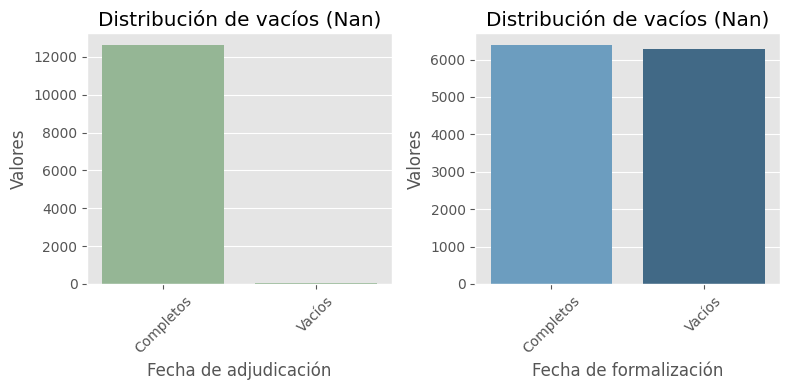

In [126]:
#Creamos los dos subplots
fig, ax = plt.subplots(
    figsize=(8, 4),
    nrows=1,
    ncols=2
)
# Creamos los DF
df_vacios_adj = pd.DataFrame({
    'Completos': [num_completo_fecha_adj],
    'Vacíos': [num_vacios_fecha_adj]
})
df_vacios_form = pd.DataFrame({
    'Completos': [num_completo_fecha_form],
    'Vacíos': [num_vacios_fecha_form]
})
# Crea el gráfico de barras en el primer subplot
sns.barplot(data=df_vacios_adj,
            color = 'darkseagreen',
            ax=ax[0]) # Use ax[0] to reference the first subplot

# Resto de campos para el primer subplot
ax[0].set_xlabel('Fecha de adjudicación')
ax[0].set_ylabel('Valores')
ax[0].set_title('Distribución de vacíos (Nan)')
ax[0].tick_params(axis='x', rotation=45)

# Crea el gráfico de barras en el segundo subplot (similar al primero)
sns.barplot(data=df_vacios_form, palette = 'Blues_d', ax=ax[1])

# Resto de campos para el segundo subplot
ax[1].set_xlabel('Fecha de formalización')
ax[1].set_ylabel('Valores')
ax[1].set_title('Distribución de vacíos (Nan)')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout() # Adjust layout for better spacing
plt.show()

Los escasos valores nulos de la 'fecha de adjudicación' vamos a tratar de rellenarlos con los valores de la 'fecha de formalización'.

Aunque no sea lo más correcto, lo cierto es que la diferencia entre una fecha y otra es muy escasa, por lo que el impacto en nuestro modelo será nulo.

Veamos si es posible.

In [127]:
df_fecha = df[['fecha_adjudicacion','fecha_formalizacion']]
df_fecha[df_fecha['fecha_adjudicacion']== df_fecha['fecha_adjudicacion'].isna()]

,fecha_adjudicacion,fecha_formalizacion


Como podemos observar, ninguna de las filas en las que el campo 'fecha adjudicación' sea nulo es posible completarlas con el campo 'fecha_formalizacion'.

Únicamente nos queda eliminar la fila 'fecha_formalización'.

In [128]:
df.drop(columns=['fecha_formalizacion'], inplace=True)

#### 2.5.4.1 Separación en Y-M-D

Una vez obtenida esta fecha única, vamos a dividirla en años, meses y días y veremos si ayuda a nuestro modelo.

In [129]:
df['año_fe'] = df['fecha_adjudicacion'].dt.year
df['mes_fe'] = df['fecha_adjudicacion'].dt.month
df['dia_fe'] = df['fecha_adjudicacion'].dt.day
df.drop(columns=['fecha_adjudicacion'], inplace=True)

<a name='item2.5.5'></a>
### 2.5.5 Variables categóricas

Las columnas 0:5 contienen los datos identificativos de cada contrato.

Estos datos se encuentran en formato texto y los hemos utilizado para determinar cuándo estamos ante un contrato **distinto**. Por tanto, nos marcan las **categorías** a las que pertenece cada uno.

Pandas tiene un tipo de dato especial denominado "categorical" que a la hora de trabajar ofrece un rendimiento mucho mayor y un mejor uso de memoria.

Sin embargo, como hemos visto en apartados anteriores estas columnas requieren de cierto tratamiento previo. Principalmente para obtener homogeneidad en sus valores.

Asimismo, existe información valiosa que puede ser **extraída** de estas columnas.

En este realizaremos un trabajo importante de _normalización_ y _feature engineering_ para intentar extraer características que puedan ser interesantes para nuestro modelo.

Procedemos a ello.

<a name = 'item2.5.5.1'></a>
#### 2.5.5.1 Tipo de contrato

El tipo de contrato determina el objeto del mismo, es decir, el tipo de constraprestación que se quiere contratar.

En nuestro dataset existen los siguientes tipos:

In [130]:
df['tipo_contrato'].value_counts()

,count
tipo_contrato,
obras,3620
servicios,3498
suministro,2997
asistencia,2339
concesión de servicios,200
concesión de obra pública,7


Con la nueva ley de 2018 el contrato de asistencia pasó a llamarse contrato de servicios. Por lo tanto, vamos a modificar aquellos valores en los que tengamos "asistencia" y lo modificaremos a "servicios", a fin de homogeneizar ambos términos.

In [131]:
df['tipo_contrato'] = df['tipo_contrato'].apply(lambda x: 'servicios' if 'asistencia' in x else x)

Asimismo, dada la excepcionalidad de los contratos de concesión que se realizan, vamos agrupar tanto el de concesión de servicios como el de obras bajo una misma categoría que es la de "concesiones".

In [132]:
df['tipo_contrato'] = df['tipo_contrato'].apply(lambda x: 'concesiones' if 'concesión de servicios' in x or 'concesión de obra pública' in x else x)

Comprobemos el resultado.

In [133]:
df['tipo_contrato'].unique()

array(['obras', 'servicios', 'suministro', 'concesiones'], dtype=object)

Cambiamos su tipología.

In [134]:
df['tipo_contrato'] = df['tipo_contrato'].astype('category')

Por último, vamos a tratar de analizar si cada una de estas categorías está balanceada respecto al resto. Para ello, crearemos una función que aplicaremos en todas estas columnas.

In [135]:
# Función para la visualización del balanceo
# ==============================================================================
def plot_count(df, columna):
  """
  Crea un countplot de la columna especificada en el DataFrame.

  Args:
    df: El DataFrame que contiene los datos.
    columna: El nombre de la columna a graficar.
  """
  plt.figure(figsize=(5, 4))
  sns.countplot(x=columna,
                data=df,
                palette = 'rocket')
  plt.xticks(rotation=90)
  plt.show()

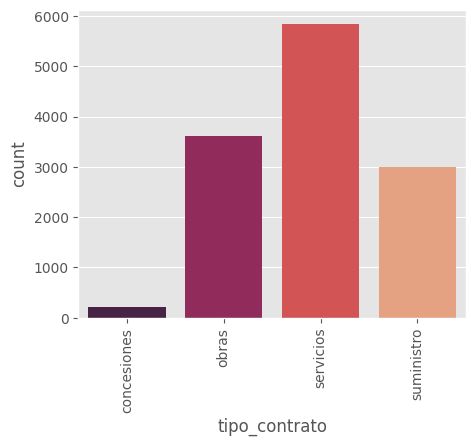

In [136]:
# Aplicamos a la categoría
plot_count(df, 'tipo_contrato')

Podemos observar una cantidad considerablemente superior de licitaciones de servicios que del resto de modaliadades.

Igualmente, habíamos comentado que la especialidad de las concesiones y su larga duración infuyen en la cantidad de procedimientos de este tipo que hay. Se ve claramente: No llega a más de 200 licitaciones de este tipo.

<a name = 'item2.5.5.2'></a>
#### 2.5.5.2 Procedimiento

Los procedimientos de licitación son los siguientes:

In [137]:
df['procedimiento'].unique()

array(['abierto', 'procedimiento simplificado',
       'negociado sin convocatoria de licitación',
       'basado en un acuerdo marco', 'restringido', 'negociado',
       'sin procedimiento',
       'basado en un sistema dinámico de adquisición',
       'negociado sin publicidad comunitaria', 'diálogo competitivo',
       'negociado con publicidad comunitaria',
       'contrato derivado de acuerdo marco'], dtype=object)

In [138]:
df[df['procedimiento'].str.contains('nan')]

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,cod_cpv,tiene_lote,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe


Como veníamos comentando la tipología del procedimiento seguido es importante, dado que cada tipo de procedimiento implica una mayor o menor publicidad y, por ende, una mayor o menor concurrencia. La **clasificación** sería la siguiente:

* **Abierto:** se trata del procedimiento que debe aplicarse como norma general y en la que puede participar cualquier persona/empresa.

* **Procedimiento simplificado**: Se trata de un procedimiento que, por su importe, tiene una publicidad más limitada y plazos más cortos, aunque por normativa deben buscarse como mínimo 5 ofertas (o, en su defecto, 3).

* **Restringido**: Se trata de un procedimiento en el que son los empresarios los que solicitan participar. Se trata de un procedimiento que existía en la anterior ley pero que con la de 2018 ha desaparecido. En cualquier caso, se exigía un mínimo de 5 participantes y un máximo de 20.

* **Basados en un acuerdo marco/sistemas dinámicos de adquisición:** Se trata de procesos en los que ha habido un procedimiento de selección previa y en esta segunda fase se negocia el contrato en base al precio (pues las empresas seleccionadas ya han cumplido una serie de requisitos). Dada su especialidad, las englobaremos en una misma categoría.

* **Sistemas dinámicos de adquisición**: Se trata de procedimientos donde se adjudican contratos de bienes o servicios genéricos mediante sistemas dinámicos, como puede ser una subasta electrónica.

* **Negociado**: Se trata de procesos en los que la especifidad del objeto o causas similares provoca que solamente uno o unos pocos licitadores puedan presentar ofertas. Aún y todo, estos procedimientos pueden darse con publicidad o sin ella.

* **Emergencia**: Se trata de aquellos casos en los que debe proveerse de un bien o servicio de manera inaplazable y urgente. Los plazos se minimizan y se puede contratar sin tener que comparar varias ofertas (este tipo de contratos se dieron mucho en el COVID).

* **Sin procedimiento**: Supuestamente se trata de un caso que no se puede dar, por lo que en principio este tipo de procedimientos no debieran existir.

De la revisión que hemos hecho anteriormente únicamente hemos visto un caso que necesita ser homogeneizado.

In [139]:
# Acuerdos
def categorizar_acuerdos(x):
  if 'marco' in str(x):
    return 'derivado de acuerdos marco'
  else:
    return x
# Aplicamos
df['procedimiento'] = df['procedimiento'].apply(categorizar_acuerdos)

Por último, modificamos el tipo de dato.

In [140]:
df['procedimiento'] = df['procedimiento'].astype('category')

Veamos si las categorías se encuentran balanceadas.

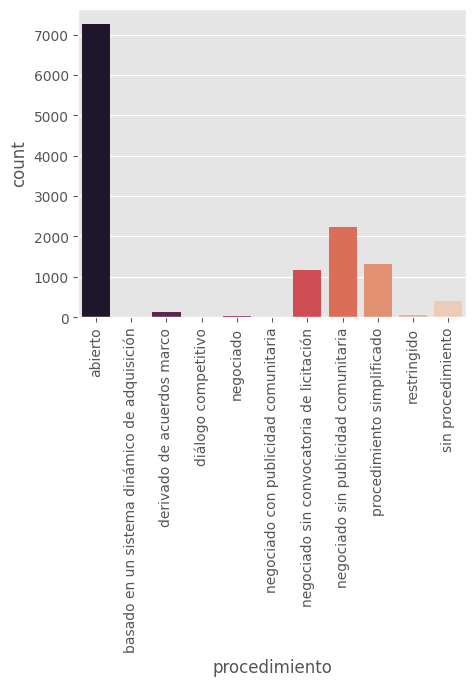

In [141]:
plot_count(df, 'procedimiento')

Queda patente que el número de procedimientos abiertos es muy superior al resto, especialmente comparado con el de los procedimientos mediante acuerdo.

<a name = 'item2.5.5.3'></a>
#### 2.5.5.3 Criterio de adjudicación

Los criterios de adjudicación son aquellos que ayudan a los órganos de contratación a elegir cuál de las ofertas presentada es la más idónea de acuerdo a las necesidades que quieren cubrir.

En este sentido, la legislación recoge lo siguiente:


> _Los contratos se adjudicarán a la oferta con la **mejor calidad precio**_.

Asimismo, la legislación recoge que '*la determinación de la oferta con la mejor calidad precio se llevará a cabo por cualquiera de las siguientes __formas__*':
* Atendiendo únicamente a criterios relacionados con la mejor *relación coste-eficacia* (precio, ciclo de vida del producto, etc.).
* Atendiendo a *criterios de coste-eficacia* junto con otros criterios *cualitativos*.
* Atendiendo solamente a *criterios cualitativos*, en cuyo caso el factor coste adoptará la forma de un precio fijo.



In [142]:
df['criterio_adjudicacion'].value_counts()

,count
criterio_adjudicacion,
mejor relación calidad-precio,4764
oferta más ventajosa,4192
mejor relación coste-eficacia: precio,1161
precio más bajo,1147
mejor relación calidad y coste-eficacia,911
mejor relación coste-eficacia: otro,453
nan,27
mejor relación coste-eficacia: coste del ciclo de vida,6


Por simplicidad, vamos a dividirlo en dos tipos solamente: aquellos que tienen algún criterio cualitativo y aquellos que no lo incluyen (los valores vacíos asumiremos que no incluyen ningún criterio cualitativo).

In [143]:
def categorizar_criterios(x):
  if 'calidad' in str(x):
    return 'cualitativo'
  elif x is None:
    return 'coste-eficacia'
  else:
    return 'coste-eficacia'

In [144]:
df['criterio_adjudicacion'] = df['criterio_adjudicacion'].apply(categorizar_criterios)

Parece que la transformación se ha completado correctamente.

Convirtámoslo ahora al tipo categorical.

In [145]:
df['criterio_adjudicacion'] = df['criterio_adjudicacion'].astype('category')

Veamos cómo se distribuyen en el dataset.

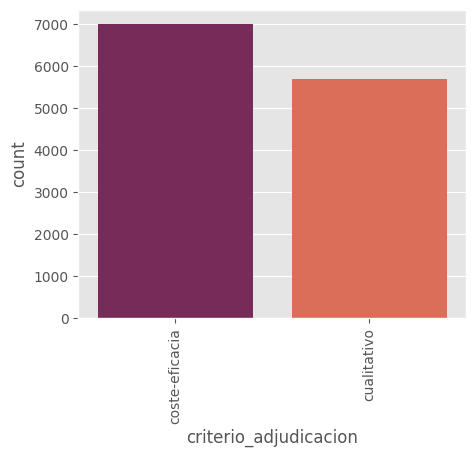

In [146]:
plot_count(df, 'criterio_adjudicacion')

En este caso parece que la utilización de un criterio u otro está bastante equilibrado.

<a name = 'item2.5.5.4'></a>
#### 2.5.5.4 Tramitación

Las modalidades de tramitación son las siguientes:

In [147]:
df['tramitacion'].unique()

array(['ordinaria', 'anticipada', 'emergencia', 'ordenaria', 'urgente'],
      dtype=object)

In [148]:
df[df['tramitacion'].str.contains('nan')]

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,cod_cpv,tiene_lote,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe


La transformación que vamos a realizar es la siguiente:
* Valores ordinaria = ordenaria --> **Ordinaria**
* Valores **anticipada**
* Valores emergencia = urgente --> **Urgente**

In [149]:
# Corregimos procedimiento ordinario
df['tramitacion']=df['tramitacion'].apply(lambda x: 'ordinaria' if 'ordenaria' in str(x) else x)

In [150]:
# Homogeneizamos procedimiento urgente
df['tramitacion'] = df['tramitacion'].apply(lambda x: 'urgente' if 'emergencia' in str(x) else x)

Tenemos solamente tres tipos.

Cambiemos ahora el tipo de dato.

In [151]:
df['tramitacion'] = df['tramitacion'].astype('category')

Y, por último, veamos si el dataset está balanceado.

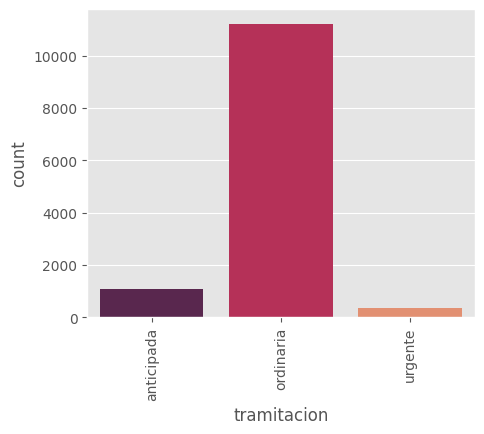

In [152]:
plot_count(df, 'tramitacion')

La tramitación ordinaria es, sin lugar a dudas, la más habitual del dataset.

<a name = 'item2.5.5.5'></a>
#### 2.5.5.5 Órganos adjudicadores

Tal y como observábamos en [apartados anteriores](item2.2.2) el concepto introducido en la columna 'adjudicador' requiere de un proceso de homogeinización.

Esto se debe a que, a lo largo del tiempo, varios órganos han modificado su nomenclatura ligeramente, lo que hace que un mismo ente aparezca escrito de diferentes formas.

In [153]:
print(f'Existen un total de {len(df["adjudicador"].unique())} entidades distintas')

Existen un total de 434 entidades distintas


Podemos verlo si introducimos palabras como 'hacienda', 'rural', etc. en la función creada anteriormente.

In [154]:
buscar_palabra(df,'hacienda','adjudicador')

array(['departamento de economía y hacienda',
       'departamento de hacienda y política financiera'], dtype=object)

Lo primero que requieren estos datos es un trabajo de **preprocesado**.

* **Preprocesado**

Al tratarse de una columna de texto que se introduce de forma manual/semimanual, lo primero que debemos hacer es una limpieza de este texto para quedarnos solamente con las palabras que pueden ser interesantes.

Hemos seguido las indicaciones de la siguiente [página](https://cr0wg4n.medium.com/palabras-vac%C3%ADas-en-espa%C3%B1ol-stop-words-ft-python-3117e52d2bff) para la creación de una función que aglutine todas estas transformaciones:
* Separación de texto.
* Transformación a minúscula.
* Eliminación de stopwords en español.
* Eliminación de signos de puntuación.
* Normalización.

In [155]:
# Cargamos las stopwords y símbolos que no nos interesan
!pip install requests # Necesario instalar esta librería

import requests
# Descargamos el contenido de las stopwords en español en la siguiente URL
url = "https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt"
response = requests.get(url)
stopwords_list = response.text.splitlines() # Separa el texto en cada palabra

# Create a Pandas Series from the list of stopwords
stopwords = pd.Series(stopwords_list)

In [156]:
# Cargamos los símbolos que queremos eliminar
symbols = [
    '¿','?','~','`','!','¡','@','#','$','%','^',
    '*','(',')','_','-','+','=','{','}','[',
    ']','\\',':',';','<','>','/', '.', ',','&','\n'
    ,'\r','\t', '|', '“', '"', '–', '”', '©', '-', '—',
    '…', ';', '‘','’'
]

In [157]:
# Funciiones para la transformación
# ==============================================================================
# Importamos librerías necesarias
import re
import string
from unicodedata import normalize

# Convertimos las columnas object a string
def to_string(text):
  'Convertimos las columnas correspondientes a string'
  if isinstance(text, str):
    return text
  else:
    return str(text)

# Separación del texto
def split_text(text):
    return re.findall(r'\S+', text)

# Eliminamos stopwords
def remove_stop_words_from_text(text) ->list:
    res = []
    subwords = split_text(text)
    for item in subwords:
        if not item in stopwords_list:
            res.append(item)
    return res

# Eliminamos los símbolos
def remove_symbols (text) -> str:
    res = text
    for char in symbols:
        res = res.replace(char, '')
    return res

# Función que engloba las demás y maneja valores nulos/vacíos
def clean_text (text) -> list:
    if text is None:
        return str(text)
    else:
        res = to_string(text)
        res = res.lower()
        # Eliminamos tildes
        res = normalize('NFKD', res).encode('ascii', 'ignore').decode('utf-8')
        res = remove_symbols(res)
        res = remove_stop_words_from_text(res)
        return res # Si queremos que no nos devuelva una lista: ' '.join(res)/res

In [158]:
# Aplicamos a las columnas que van a ser modificadas
df['adjudicador'] = df['adjudicador'].apply(clean_text)

* **Extracción de características**

Hemos dividido las distintas palabras del texto y las hemos separado en una lista.

Como podemos ver, el primer objeto de la lista recoge si se trata de un 'departamento', 'ayuntamiento', 'mancomunidad'. Extrayendo ese primer objeto y guardándolo en una nueva columna vamos a poder clasificar los tipos de entidades que hay.

Sin embargo, debemos tener en cuenta que no todas nos pueden servir como un clasificador, por lo que vamos comenzar por examinar qué texto estamos aislando

In [159]:
adj = df.copy()

In [160]:
adj['tipo_entidad'] = adj['adjudicador'].apply(lambda x: x[0])

In [161]:
adj.groupby('tipo_entidad').agg(
    {'adjudicador':'count'}
).sort_values(by='adjudicador', ascending=False).head(10)

,adjudicador
tipo_entidad,
ayuntamiento,4281
departamento,2939
servicio,1088
navarra,935
servicios,684
universidad,449
mancomunidad,321
instituto,257
asociacion,198


La nueva columna tendría 62 valores distintos.

Sin embargo, algunos de ellos son solamente la primera palabra de su nombre o razón social, por lo que no nos sirve para su categorización.

En esta aproximación y basándonos en la legislación actual podemos considerar como categorías las siguientes:
* Departamento
* Ayuntamiento.
* Concejo.
* Mancomunidad.
* Universidad.
* Consorocio.
* Corporación
* Fundación.
* Sociedad.

Por el momento crearemos la columna nueva solamente en aquellos casos que tengamos uno de estos valores.

In [162]:
# Función para la clasificación de entidades
# ==============================================================================
def tipo_entidad(valor):
  tipo = ['departamento','ayuntamiento','concejo','mancomunidad','universidad','consorcio','corporacion','fundacion','sociedad']
  if isinstance(valor, list) and valor:
    primer_valor = valor[0]  # Accedemos al primer elemento sin extraerlo
    if primer_valor in tipo:
      valor.pop(0) # Extraemos el primer elemento si coincide con un tipo
      return primer_valor
  return None  # Devuelve None si no es una lista, está vacía o el primer valor no coincide

In [163]:
df['tipo_entidad_fe'] = df['adjudicador'].apply(tipo_entidad)

In [164]:
df['tipo_entidad_fe'].value_counts(dropna=False)

,count
tipo_entidad_fe,
None,4326
ayuntamiento,4281
departamento,2939
universidad,449
mancomunidad,321
fundacion,181
concejo,89
corporacion,34
consorcio,28


Vemos que la transformación se ha realizado con éxito pero que existen un considerable número de valores vacíos.

Ahora tenemos que analizar el resto de adjudicadores para ver a qué categoría pertenecen.

Analizando el listado anterior podemos destacar lo siguiente:
* El primero de todos los adjudicadores sin clasificar es el Servicio Navarro de Salud. Este se trataría de un **'organismo autónomo'**, un tipo de entidad pública asociada a los departamentos pero con cierta independencia en su gestión. Dentro de esta misma categoría tendríamos a los diversos 'institutos' (el de igualdad, salud pública...) y las 'agencias', que en nuestro caso es solamente la 'agencia navarra para la dependencia'. Puede consultarse la siguiente [página](https://gobiernoabierto.navarra.es/es/transparencia/organismos-autonomos).

* Los adjudicadores que entre sus palabras contienen 'sa', 'sl' y 'sau' serían sociedades públicas, por lo que los introduciremos en la categoría de **sociedad**.

* El resto no tienen un patrón un patrón claro. En su mayoría son otras instituciones públicas que no tienen una gran peso en las licitaciones efectuadas. Por lo tanto los categorizaremos con el genérico nombre de **'Otras instituciones y entidades'**.

Siguiendo este criterio completaremos el resto de la columna:

In [165]:
# Función para la clasificación de entidades
# ==============================================================================
def rellena_tipo_entidad(df):
  """
  Rellena los valores vacíos de la columna 'tipo_entidad_fe' basándose en los valores de la columna 'adjudicador'.
  Args:
    df: DataFrame de pandas.
  Returns:
    El DataFrame modificado.
  """
  for index, row in df.iterrows():
    if pd.isna(row['tipo_entidad_fe']):
      if isinstance(row['adjudicador'], list):
        # Definimos cuáles son sociedades
        if any(valor in row['adjudicador'] for valor in ['sa', 'sau', 'sl']):
          df.at[index, 'tipo_entidad_fe'] = 'sociedad'
        # Definimos cuáles son organismos autónomos
        elif 'instituto' in row['adjudicador'] or 'servicio'\
        and 'salud' in row['adjudicador'] or 'agencia' in row['adjudicador']:
          df.at[index, 'tipo_entidad_fe'] = 'organismo autonomo'
        # Definimos el resto
        else:
          df.at[index, 'tipo_entidad_fe'] = 'Otras instituciones y entidades'
  return df

In [166]:
# Aplicamos la función
rellena_tipo_entidad(df).head(5)

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,cod_cpv,tiene_lote,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe,tipo_entidad_fe
0,"[agencia, navarra, dependencia]",obras,abierto,cualitativo,ordinaria,480950.36,363598.47,418217.70,False,False,False,45215000.0,False,5.00,1,1,419.75,2023.00,1.00,16.00,organismo autonomo
21,"[agencia, navarra, dependencia]",servicios,abierto,cualitativo,ordinaria,622618.67,100146.12,101656.36,False,False,True,98311100.0,False,1.00,1,1,1800.00,2023.00,2.00,14.00,organismo autonomo
28,"[agencia, navarra, dependencia]",suministro,procedimiento simplificado,cualitativo,ordinaria,29250.00,22231.26,29250.00,False,False,False,39100000.0,True,2.00,4,1,365.00,2023.00,5.00,8.00,organismo autonomo
32,"[agencia, navarra, dependencia]",obras,procedimiento simplificado,cualitativo,ordinaria,152757.03,134336.67,143703.70,False,False,False,45331230.0,False,2.00,1,1,387.99,2023.00,5.00,30.00,organismo autonomo
33,"[agencia, navarra, dependencia]",suministro,abierto,cualitativo,ordinaria,134031.00,99327.79,119670.54,False,False,False,39100000.0,True,6.00,5,3,408.80,2023.00,5.00,30.00,organismo autonomo


Finalmente. lo transformamos a tipo categorical.

In [167]:
df['tipo_entidad_fe'] = df['tipo_entidad_fe'].astype('category')

Y analizamos su distribución:

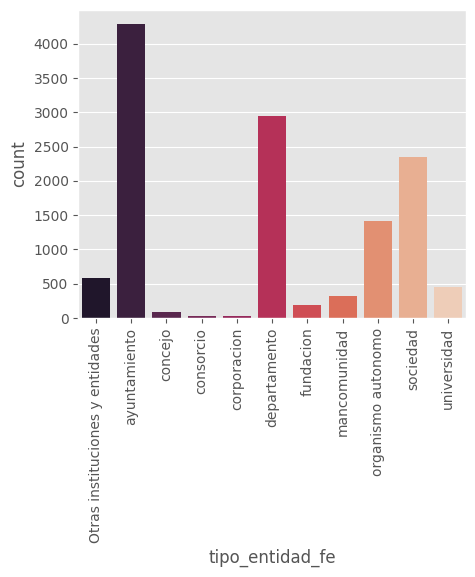

In [168]:
plot_count(df, 'tipo_entidad_fe')

Queda patente que la mayor parte de los contratos son licitados por Ayuntamientos y por los Departamentos del Gobierno de Navarra y sus sociedades públicas.

* **Identificador de parecidos**

Una vez extraídas las características que necesitábamos vamos a tratar de corregir la columna 'adjudicador'.

Para ello, en primer lugar vamos a volver a convertirlo en un string.

In [169]:
# Conversión de la varaible
df['adjudicador'] = df['adjudicador'].apply(tuple)
df['adjudicador'] = df['adjudicador'].apply(' '.join)

# Ahora podemos contar el número de valores únicos
len(df['adjudicador'].unique())

433

Vamos a utilizar ```SequenceMatcher```del módulo ```difflib```, muy utilizado para comparar secuencias.



In [170]:
# Función para la detección de nombres similares
# ==============================================================================
from difflib import SequenceMatcher

adjudicador1 = df['adjudicador'].unique()
adjudicador2 = df['adjudicador'].unique()

data_dict = {"nombre_adj1":[], "nombre_adj2":[], "ratio":[]}

for x in adjudicador1:
  for y in adjudicador2:
    ratio = SequenceMatcher(None, x, y).ratio()
    data_dict["nombre_adj1"].append(x)
    data_dict["nombre_adj2"].append(y)
    data_dict["ratio"].append(ratio)

df_ratio = pd.DataFrame(data_dict)


Con esta función estamos creando un df en el que aparecerá resumido cuál es la ratio de similitud de los distintos nombres que estamos analizando.

Vamos a analizar solamente los que tienen la ratio superior al 70% e inferior al 100% (pues estamos comparando la misma columna).

Posteriormente las analizaremos una por una cuáles son susceptibles de homogeneizar (no existe otro método ya que hay nombres de municipios que, sin ser el mismo, se parecen mucho).

In [171]:
df_ratio[(df_ratio['ratio'].astype(float) > 0.70) & (df_ratio['ratio'].astype(float)<1)].sort_values(by='ratio', ascending=False)


,nombre_adj1,nombre_adj2,ratio
822,asociacion navarra informatica municipal sa an...,asociacion navarra informatica municipalsa animsa,0.99
168438,asociacion navarra informatica municipalsa animsa,asociacion navarra informatica municipal sa an...,0.99
168848,asociacion navarra informatica municipalsa animsa,asociacion navarra informatica municipal animsa,0.98
178352,asociacion navarra informatica municipal animsa,asociacion navarra informatica municipalsa animsa,0.98
844,asociacion navarra informatica municipal sa an...,asociacion navarra informatica municipal animsa,0.97
...,...,...,...
11986,baranain,garinoain,0.71
140587,orisoain,garinoain,0.71
12448,barasoain,orisoain,0.71
140320,orisoain,barasoain,0.71


Hemos detectado los siguientes:

1. ANIMSA.
2. Cintruenigo.
3. Fundación Jorge Oteiza.
4. Instituto Navarro de deporte y juventud --> Instituto, deporte, juventud
5. Navarra Impulsa, Cultura, Deporte y Ocio --> NICDO --> Cultura, deporte y ocio
6. Servicios sociales bortziriakcinco villas.
7. Departamento de Desarrollo Rural y Medio Ambiente.
8. Departamento de Relaciones Ciudadanas
9. Departamento de Presidencia, Función Pública, Interior y Justicia.
10. Departamento de Economía y Hacienda


Procedemos a homogeneizarlos.

In [172]:
def sustituir_adjudicatario(valor):
  if 'animsa' in valor:
    return 'animsa'
  elif 'citruenigo' in valor:
    return 'cintruenigo'
  elif 'oteiza' in valor:
    return 'fundacion museo jorge oteiza'
  elif 'deporte' in valor and 'instituto' in valor:
    return 'instituto navarro de deporte'
  elif 'deporte' in valor and 'instituto' in valor and 'navarro' in valor:
    return 'nicdo'
  elif'bortziriak' in valor:
    return 'servicios sociales bortziriak'
  elif 'desarrollo' in valor and 'rural' in valor:
    return 'desarrollo rural y medio ambiente'
  elif 'relaciones' in valor and 'ciudadanas' in valor:
    return 'relaciones ciudadanas'
  elif 'presidencia' in valor and 'funcion' in valor and 'publica' in valor:
    return 'presidencia y funcion publica'
  elif 'hacienda' in valor:
    return 'economia y hacienda'
  else:
    return valor

In [173]:
df['adjudicador'] = df['adjudicador'].apply(sustituir_adjudicatario)

In [174]:
print('Con anterioridad a este procesado teníamos un total de {} entidades'.format(len(dataset['adjudicador'].unique())))
print('Ahora tenemos un total de {} entidades'.format(len(df['adjudicador'].unique())))

Con anterioridad a este procesado teníamos un total de 436 entidades
Ahora tenemos un total de 424 entidades


Por último, lo transformamos a una variable categórica.

In [175]:
df['adjudicador'] = df['adjudicador'].astype('category')

<a name = 'item2.5.5.6'></a>
#### 2.5.5.6 Sector del CPV (Common Procurement Vocabulary - Vocabulario Comnún de Contratación)

Por último, vamos a extraer información acerca de la clasificación a nivel europeo que se le ha dado a cada contrato.

Para ello, cogeremos solamente los dos primeros dígitos de la variable CPV.

**Nota**: El tipo de sector viene definido en el botelín europeo [(EC) No 213/2008](https://eur-lex.europa.eu/eli/reg/2008/213/oj).

In [176]:
# Extremos los dos primeros dígitos
df['subcod_cpv_fe'] = df['cod_cpv'].astype(str).str[:2]

Hemos detectado una serie de valores en las columnas 'cod_cpv' y 'subcod_cpv_fe' que tenían valor NaN pero que al transformarlas a tipo texto no habían sido detectadas.

Dichos valores van a ser devueltos a su estado original, de forma que posteriormente puedan ser tratados debidamente.

In [177]:
def valor_nulo (valor):
  if valor == 'nan' or valor == 'na':
    return np.nan
  else:
    return valor

In [178]:
df['cod_cpv'] = df['cod_cpv'].apply(valor_nulo)
df['subcod_cpv_fe'] = df['subcod_cpv_fe'].apply(valor_nulo)

In [179]:
# Cambiamos la tipología
df['cod_cpv'] = df['cod_cpv'].astype('category')
df['subcod_cpv_fe'] = df['subcod_cpv_fe'].astype('category')

Visualicemos cuál es el tipo de contrato más habitual.

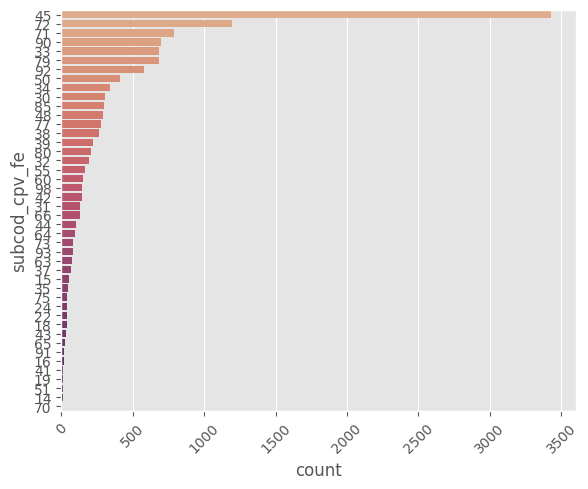

In [180]:
plt.figure(figsize=(6,5))
sns.countplot(y='subcod_cpv_fe',
              data=df,
              palette = 'flare',
              order = df['subcod_cpv_fe'].value_counts().index
              )
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta el espaciado
plt.show()

Las 5 primeras categorías son las siguientes:
* **45**: Construcción. Se observa que la gran mayoría de las licitaciones tienen como objeto una construcción u obra.
* **72**: Servicios de IT, consultoría, desarrollo de software y soporte.
* **71**: Arquitectura, construcción e ingeniería.
* **90**: Limpieza y servicios medioambientales.
* **33**: Equipamiento médico, farmacéutico y de cuidado personal.

<a name='item2.5.6'></a>
### 2.5.6 Tratamiento de datos ausentes (NaN)

Incluso después de todo el trabajo realizado previamente seguimos encontrando valores ausentes en algunos de los campos más importantes de nuestro dataset.

In [181]:
estado_df(df)

                         nulos  completo  porcentaje
adjudicador                  0     12661        0.00
tipo_contrato                0     12661        0.00
procedimiento                0     12661        0.00
criterio_adjudicacion        0     12661        0.00
tramitacion                  0     12661        0.00
valor_estimado             298     12363        2.35
importe_adj                  0     12661        0.00
importe_estimado          2897      9764       22.88
rev_precios                  0     12661        0.00
plurianual                   0     12661        0.00
prorroga                     0     12661        0.00
cod_cpv                     16     12645        0.13
tiene_lote                   0     12661        0.00
no_ofertas                2725      9936       21.52
no_de_lotes_fe               0     12661        0.00
no_de_adjudicatarios_fe      0     12661        0.00
duracion_fe                  6     12655        0.05
año_fe                      50     12611      

Para solucionar este problema contamos con varios **criterios** que pueden ayudarnos a completar una buena parte de esos valores perdidos (NaN) sin incurrir en incoherencias o sesgar los datos.

Adicionalmente, trataremos de completar los datos restantes siguiendo diversos métodos de la librería [scikit-learn](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py).

<a name = 'item2.5.6.1'></a>
#### 2.5.6.1 Importe estimado

El importe estimado es una de las variables más importantes para nuestro modelo posterior.

Como habíamos comentado, es la estimación del coste anual que va a tener un contrato. Sin embargo, aún después de todas las modificaciones que hemos realizado, se trata de uno de los campos que más valores vacíos tienen, con casi un 23%.

Gran parte de estos valores se encuentran vacíos por errores al completar los datos y son subsanables mediante la información contenida en otros campos, especialmente con la información del **valor estimado** y del **importe de adjudicación**.

A continuación vamos a explicar los **criterios** utilizados para extraer información valiosa de nuestro dataset e incorporarla a la columna del importe estimado.

* **El importe adjudicado es igual al valor estimado**

Existen una serie de casos en los que el valor de adjudicación de un contrato es igual a su valor estimado.

Esto solo puede singificar que su importe estimado era _exactamente igual_.

**Nota**: Sin duda esto puede deberse a que los gestores, a la hora de rellenar los distintos campos, consideran que cuando el valor estimado y el importe estimado son el mismo basta con rellenar uno de los dos.

* **El importe de adjudicación indica que es un contrato inferior al año**

Ya al inicio de este notebook hemos indicado que el importe estimado y el valor esimtado están estrechamente relacionados. El valor estimado es el presupuesto total del contrato y el importe estimado sería su anualidad (estimada).

$$ ValorEstimado = ImporteEstimado*X $$
$$ X = Duracion $$

Si
$$X = 1$$ entonces $$ValorEstimado=ImporteEstimado$$

Y si

$$ 1 <= X < 2 $$

Igualmente debemos recordar que el importe de adjudicación siempre será una cantidad **menor o igual** al importe estimado, pero que tampoco puede ser infinitamente menor.

La legislación recoge que cada procedimiento determinará el importe a partir del cuál se considera una oferta anormalmente baja. Sin embargo, en la norma anterior se recogía que era en torno a **30 puntos porcentuales**.

Considerando que el contrato es anual y, por tanto, $ValorEstimado = ImporteEstimado$:

$$ValorEstimado * Y = ImporteAdjudicacion$$
$$ Y = Rebaja$$

$$ 0.7 < Y < 1$$

Siguiendo con esta lógica y llevándolo al caso más basico donde el $ValorEstimado = 1$ y se está aplicando la bajada mínima, es decir, $ImporteAdjudicacion=1$, obtenemos que el límite máximo **es el mismo**:

$$ 1 < ValorEstimado/ImporteAdj < 2$$

Es decir, la ratio entre ambos términos puede ser como máximo 2.

En consecuencia, cuando calculamos **la ratio** entre el valor estimado y el importe por el que finalmente se ha adjudicado el contrato, podemos obtener diversos resultados.

> **Igual a 1**. Es decir, el contrato se ha adjudicado por el mismo valor que su presupuesto inicial (sería el caso anteriormente mencionado).

> **Entre 1 y 2**. Quiere decir que el precio de adjudicación era inferior al del presupuesto inicial y que el contrato tendrá una duración inferior al año.

> **Superior a 2**. En estos casos ya estamos ante contratos superiores al año.

Cuando estemos ante una de las dos primeras situaciones podemos asumir que el **el valor estimado y el importe estimado son iguales**, por lo que podemos sustituir uno por el otro.

* **El resultado del valor estimado entre el importe de adjudicación es un número entero**

Siguiendo la lógica anterior, el valor estimado es el producto del importe estimado por su duración.

Cuando nos encontramos con que el resultado de la división entre:

$$ ValorEstimado / ImporteAdjudicacion$$

es un número entero, estamos ante un caso en que el $$ImporteEstimado = ImporteAdjudicacion$$.

In [182]:
# Función para corregir la columna 'importe_estimado'
# ==============================================================================
def rellenar_importe_estimado(row): # Vamos a revisar por fila
    # Creamos una máscara para las filas donde el ie sea 0 o nulo
    mask = (pd.isna(row['importe_estimado'])) | (row['importe_estimado'] == 0)

    # Casos donde 'importe_adj' no es 0 y se cumplen las condiciones
    if mask and (row['importe_adj'] != 0) and (row['valor_estimado'] / row['importe_adj'] < 2):
        row['importe_estimado'] = row['valor_estimado']
    elif mask and (row['importe_adj'] != 0) and (row['valor_estimado'] % row['importe_adj'] == 0):
        row['importe_estimado'] = row['importe_adj']

    return row  # Devolvemos las filas

In [183]:
# Aplicamos la función creada
df['importe_estimado'] = df.apply(rellenar_importe_estimado, axis=1)['importe_estimado'] # Extract the 'importe_estimado' column from the result


Por último, hemos observado la existencia de licitaciones en las que se da que:

$$ImporteAdjudicacion > ImporteEstimado$$

La normativa no contempla esta situación, por lo que procedemos a eliminar dichas observaciones, ya que afectan a variables fundamentales para nuestro modelo posterior.

In [184]:
df = df[df['importe_estimado'] >= df['importe_adj']]

Tras aplicar estos criterios, nuestro dataset queda de la siguiente forma.

In [185]:
estado_df(df)

                         nulos  completo  porcentaje
adjudicador                  0     11568        0.00
tipo_contrato                0     11568        0.00
procedimiento                0     11568        0.00
criterio_adjudicacion        0     11568        0.00
tramitacion                  0     11568        0.00
valor_estimado              27     11541        0.23
importe_adj                  0     11568        0.00
importe_estimado             0     11568        0.00
rev_precios                  0     11568        0.00
plurianual                   0     11568        0.00
prorroga                     0     11568        0.00
cod_cpv                     16     11552        0.14
tiene_lote                   0     11568        0.00
no_ofertas                1848      9720       15.98
no_de_lotes_fe               0     11568        0.00
no_de_adjudicatarios_fe      0     11568        0.00
duracion_fe                  3     11565        0.03
año_fe                      43     11525      

<a name = 'item2.5.6.2'></a>
#### 2.5.6.2 Número de ofertas

El número de ofertas recibidas es un campo muy interesante del que obtenemos información valiosa sobre el nivel de concurrencia de una licitación.

Sin embargo, al igual que nos ocurría con el campo anterior, sigue teniendo un elevado número de valores vacíos (NaN).

Veamos si es posible completar alguno de ellos.

In [186]:
n_ofertas_nulo = df[df['no_ofertas'].isna()]

In [187]:
n_ofertas_nulo.groupby(['adjudicador','procedimiento']).agg(
    {'importe_adj':'sum'}
).sort_values(by='importe_adj', ascending=False).head(10)

,,importe_adj
adjudicador,procedimiento,
fomento,abierto,5060314257.83
servicio navarro salud osasunbidea,abierto,632972458.64
pamplona,abierto,478165930.17
educacion,abierto,341451567.82
presidencia y funcion publica,abierto,313544430.50
autopistas navarra sa audenasa,abierto,264464003.69
instituto navarro tecnologias infraestructuras agroalimentarias sa,abierto,252101634.88
navarra infraestructuras locales sa nilsa,abierto,174982406.37
educacion,negociado sin publicidad comunitaria,123100569.53


Para lidiar con este problema vamos a utilizar el paquete [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#iterativeimputer) proporcionado por la libreria scikit-learn.

Este método sigue la estrategia de completar los valores vacíos utilizando modelizando un estimador a partir de otras características que nosotros determinemos.

# 3. ANÁLISIS ESTADÍSTICO Y DETECCIÓN DE OUTLIERS

## 3.1 Análisis variables

Los outliers son las muestras que están distantes del resto de observaciones.

Este tipo de observaciones que están alejados del resto de los datos pueden afectar de forma importante a nuestro modelo dependiendo de si se tratan de:
* **Errores**, en cuyo caso los eliminaremos.
* **Límites**, por lo que los mantendremos por el momento y veremos qué tal se comportan en nuestro modelo.
* **Puntos de interés** para nuestro modelo.

Por lo tanto, es recomendable tenerlos localizados.

Vamos a comenzar por elaborar un __histograma__ para analizar la distribución de nuestras variables numéricas.

<Figure size 1000x800 with 0 Axes>

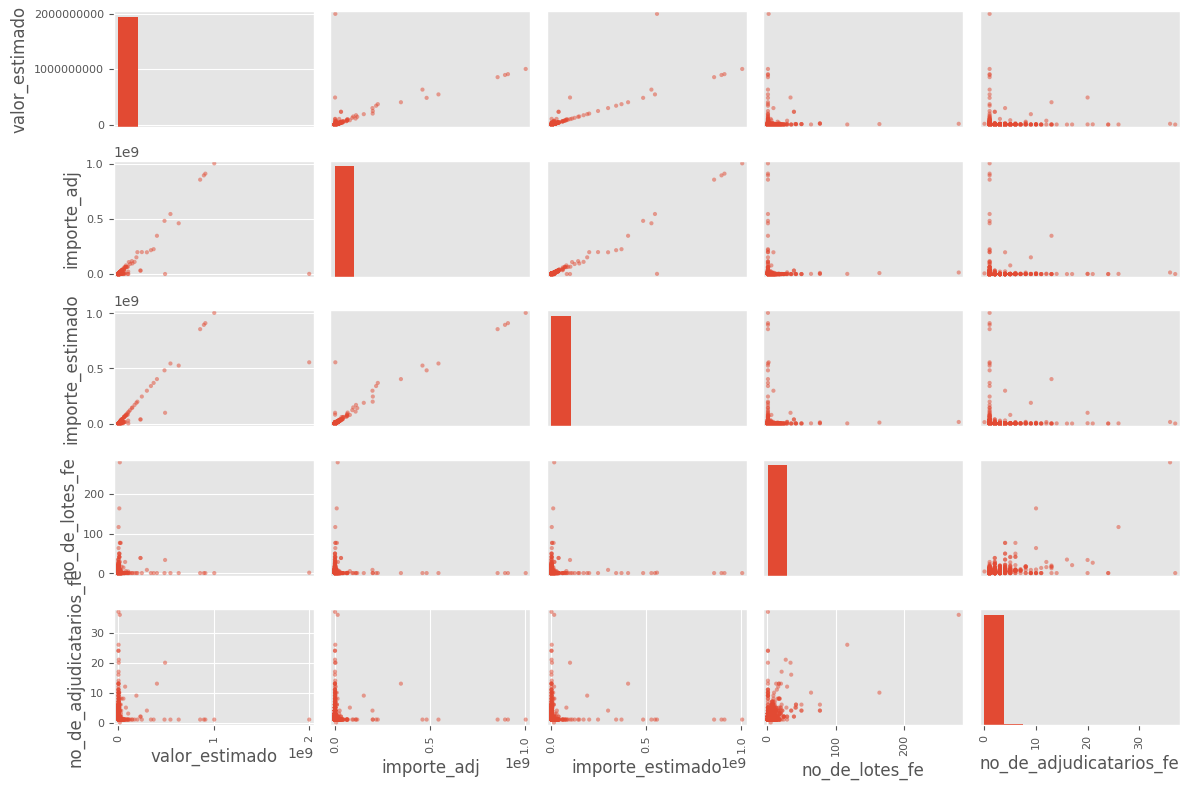

In [188]:
# Gráficas de dispersión de las variables numéricas
# ==============================================================================
# Usamos pandas.plotting.scatter_matrix
plt.figure(figsize=(10,8))
pd.plotting.scatter_matrix(df[['valor_estimado','importe_adj','importe_estimado','no_de_lotes_fe','no_de_adjudicatarios_fe']],figsize=(12,8))
plt.tight_layout() # Ajusta el espaciado
plt.grid(False)
plt.show()

Como puede observarse existe una **gran dispersión** en las observaciones de cada una de estas variables. Todas ellas muestran una gran concentración de observaciones en el primer tramo del eje X, es decir, en torno a valores pequeños.

Sin embargo, la cola se alagra (y es casi invisible) por el hecho de que existen valores de millones de euros entre algunas licitaciones.

Veamos con el método **describe()** los máximos y mínimos de cada una de estas.

In [189]:
df.describe().applymap(lambda x: f'{x:.2f}')

,valor_estimado,importe_adj,importe_estimado,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe
count,11541.00,11568.00,11568.00,9720.00,11568.00,11568.00,11565.00,11525.00,11525.00,11525.00
mean,1801052.65,1092739.24,1321183.09,2.96,1.57,1.17,615.28,2019.12,7.26,16.36
std,28766832.39,19957339.55,21502035.10,2.85,4.16,1.00,527.18,2.97,3.32,8.91
min,0.00,0.00,0.00,0.00,1.00,0.00,-84.00,2012.00,1.00,1.00
25%,40005.93,25000.00,29672.57,1.00,1.00,1.00,365.00,2017.00,5.00,9.00
50%,96373.59,59417.61,70000.00,2.00,1.00,1.00,365.00,2019.00,7.00,17.00
75%,312907.38,161938.92,192979.53,4.00,1.00,1.00,730.00,2022.00,10.00,24.00
max,1999555527.00,1004506033.00,1004506033.00,52.00,280.00,37.00,1825.00,2024.00,12.00,31.00


Por último, veamos cuántas de nuestras variables siguen una distribución normal.

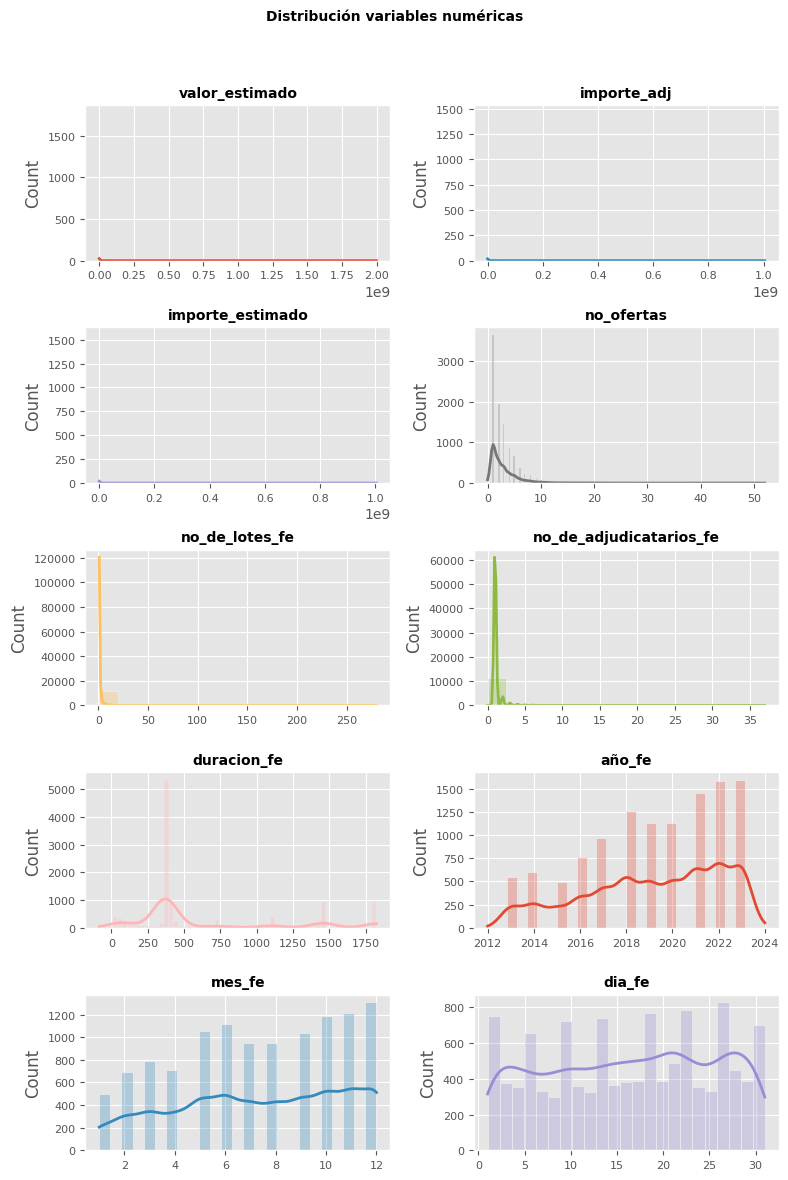

In [190]:
# Gráficas de distribución de las variables numéricas
# ==============================================================================
# Ajustamos el número de subplots
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (8,12))
axes = axes.flat
columns_numeric = df.select_dtypes(include=['float64', 'int64']).columns

for i, colum in enumerate(columns_numeric):
  sns.histplot(data = df,
               x = colum,
               stat = 'count',
               kde = True,
               color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               line_kws= {'linewidth': 2},
               alpha   = 0.3,
               ax = axes[i]
               )
  axes[i].set_title(colum, fontsize = 10, fontweight = 'bold')
  axes[i].tick_params(labelsize = 8)
  axes[i].set_xlabel('')

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

### 3.1.1 Valor estimado, importe estimado e importe de adjudicación

Por un lado, observamos que los valores **mínimos** en las columnas 'valor estimado', 'importe adj' e 'importe estimado' tienen valor 0. Esto no es posible y debiera corregirse.

In [191]:
num_filas_con_error = ((df['valor_estimado']==0) | (df['importe_adj']==0) | (df['importe_estimado']==0)).sum()

print('Existen un total de {} filas en los que alguno de estos valores es 0'.format(num_filas_con_error))

Existen un total de 50 filas en los que alguno de estos valores es 0


Igualmente, existen incoherencias entre los valores **máximos**.

Por ejemplo en el campo 'valor_estimado' el mayor importe es de más de 1.000 millones de euros, lo que supondría más de una quinta parte de los Presupuestos Generales de Navarra (es decir, una cifra imposible).

Podemos detectar varios outliers al calcular  **las ratios** entre el

$$ValorEstimado/ImporteEstimado$$ y el $$ImporteEstimado/ImporteAdj$$

Esto nos dará una medida de la relación entre ambos importes.

In [192]:
df['ratio'] = (round(df['valor_estimado']/df['importe_estimado'],2)*100).astype(float)
df['ratio_II']= (round(df['importe_estimado']/df['importe_adj'],2)*100).astype(float)

Veamos qué datos nos aportan estas variables:

In [193]:
df[['ratio','ratio_II']].describe()

,ratio,ratio_II
count,11529.00,11547.00
mean,inf,inf
std,NaN,NaN
min,71.00,100.00
25%,100.00,100.00
50%,100.00,106.00
75%,120.00,123.00
max,inf,inf


Como podemos observar ambas columnas tienen una serie de valores cuyo resultado da error, claramente influenciado por los valores que anteriormente hemos observado que tienen valor 0.

Veamos cuántas filas de nuestro dataset tienen una ratio que es claramente desorbitante; pongamos que unas 100.000 superior de una valor a otro.

In [194]:
df_error = df[(df['ratio']>100000) | (df['ratio_II']>100000)]
print('Tenemos un total de {} filas que presentan valores extremadamente altos'.format(df_error.shape[0]))

Tenemos un total de 96 filas que presentan valores extremadamente altos


In [195]:
# Eliminamos este grupo ya que debe tratarse de errores
df = df[(df['ratio']<100000)&
    (df['ratio_II']<100000)]

A continuación, utilizaremos la siguiente función para comparar dos variables y observar qué puntos se alejan del rango o área en el que pueden ser considerados outliers.

Para ello, hemos seguido las indicaciones de la siguiente [fuente](https://www.aprendemachinelearning.com/deteccion-de-outliers-en-python-anomalia/).

In [196]:
# Función para detectar outliers
# ==============================================================================
def outliers(column1, column2):
  #Definimos las variables
  media_x = column1.mean()
  std_x = column1.std()*2
  media_y = column2.mean()
  std_y = column2.std()*2
  colors = ['blue']*len(column1)

  # Definimos las funciones
  for index, x in enumerate(column1):
    if abs(x-media_x) > std_x:
      colors[index] = 'red'
  for index, y in enumerate(column2):
    if abs(y-media_y) > std_y:
      colors[index] = 'orange'

  # Creamos el gráfico interactivo con Plotly
  fig = px.scatter(x=column1, y=column2, color=colors,
                 title=f"Outliers en {column1.name} vs {column2.name}",
                 labels={'x': column1.name, 'y': column2.name, 'color': 'Outlier'})

  # Añadimos las líneas de la media y la elipse
  fig.add_shape(type="line", x0=media_x, x1=media_x, y0=column2.min(), y1=column2.max(),
              line=dict(color="black", dash="dash"))
  fig.add_shape(type="line", y0=media_y, y1=media_y, x0=column1.min(), x1=column1.max(),
              line=dict(color="black", dash="dash"))

  v = media_x
  u = media_y
  b = std_x
  a = std_y
  t = np.linspace(0,2*np.pi,100)
  x_ellipse = v + a*np.cos(t)
  y_ellipse = u + b*np.sin(t)
  fig.add_scatter(x=x_ellipse, y=y_ellipse, mode='lines', line=dict(color="black"))

  # Mostramos el gráfico
  fig.show()

Vamos a aplicar esta función a los ratios creados.

In [197]:
# Ponemos las variables que queramos
outliers(df['ratio'], df['ratio_II'])

En este punto, es necesario realizar un primer filtrado de los outliers que hemos detectado se deben a **errores**, que son:
* Licitaciones con ratios superiores al 700%.
* Importe de adjudicación inferiores 150 euros.
* Importe estimados superiores superiores a

In [198]:
# Incorporamos el filtro al df
df = df[(df['ratio'] < 700) &
                  (df['ratio_II'] < 700) &
                  (df['importe_adj'] > 150) &
                  (df['importe_estimado'] < 10000000)]
df.shape

(10989, 24)

### 3.1.2 Nº de lotes, de adjudicatarios y de ofertas

In [199]:
# Ponemos las variables que queramos
outliers(df['no_de_lotes_fe'], df['no_de_adjudicatarios_fe'])

In [200]:
# Creamos una máscara booleana que identifica las filas que queremos MANTENER
mask = ~((df['no_de_lotes_fe'] == 1) & (df['no_de_adjudicatarios_fe'] > 1))

# Filtramos el DataFrame para mantener solo las filas que cumplen la condición
df = df[mask]

# Mostramos la forma del DataFrame resultante
df.shape

(10812, 24)

Hemos eliminado un total de 185 filas.

In [201]:
# Ponemos las variables que queramos
outliers(df['no_ofertas'], df['no_de_adjudicatarios_fe'])

* **Nº de ofertas**

Asimismo, observamos que hay una serie de observaciones en las que el número de adjudicadores excede el número de ofertas. Esto no es posible y, por tanto, vamos a eliminar dichas filas.

In [202]:
def ofertas_correctas (df):
  if (df['no_ofertas'] != 0).any():
  #Creamos una máscara booleana con la que identificamos las filas que queremos mantener
    mask = (df['no_ofertas'] >= df['no_de_adjudicatarios_fe'])
  # Filtramos el DataFrame para mantener solo las filas que cumplen la condición
    df = df[mask]
    return df
  else:
    return df

In [203]:
ofertas_correctas(df)

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,prorroga,cod_cpv,tiene_lote,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe,tipo_entidad_fe,subcod_cpv_fe,ratio,ratio_II
0,agencia navarra dependencia,obras,abierto,cualitativo,ordinaria,480950.36,363598.47,418217.70,False,False,False,45215000.0,False,5.00,1,1,419.75,2023.00,1.00,16.00,organismo autonomo,45,115.00,115.00
21,agencia navarra dependencia,servicios,abierto,cualitativo,ordinaria,622618.67,100146.12,101656.36,False,False,True,98311100.0,False,1.00,1,1,1800.00,2023.00,2.00,14.00,organismo autonomo,98,612.00,102.00
28,agencia navarra dependencia,suministro,procedimiento simplificado,cualitativo,ordinaria,29250.00,22231.26,29250.00,False,False,False,39100000.0,True,2.00,4,1,365.00,2023.00,5.00,8.00,organismo autonomo,39,100.00,132.00
32,agencia navarra dependencia,obras,procedimiento simplificado,cualitativo,ordinaria,152757.03,134336.67,143703.70,False,False,False,45331230.0,False,2.00,1,1,387.99,2023.00,5.00,30.00,organismo autonomo,45,106.00,107.00
33,agencia navarra dependencia,suministro,abierto,cualitativo,ordinaria,134031.00,99327.79,119670.54,False,False,False,39100000.0,True,6.00,5,3,408.80,2023.00,5.00,30.00,organismo autonomo,39,112.00,120.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24428,publica navarra,servicios,negociado sin publicidad comunitaria,coste-eficacia,ordinaria,29895.00,29895.00,29895.00,False,False,False,48100000.0,False,1.00,1,1,365.00,2016.00,6.00,13.00,universidad,48,100.00,100.00
24429,publica navarra,servicios,negociado sin publicidad comunitaria,coste-eficacia,ordinaria,50400.00,50400.00,50400.00,False,True,True,48218000.0,False,1.00,1,1,1460.00,2016.00,6.00,8.00,universidad,48,100.00,100.00
24431,publica navarra,suministro,abierto,coste-eficacia,ordinaria,198347.11,105156.00,198347.11,False,False,False,32428000.0,False,5.00,1,1,90.00,2016.00,6.00,28.00,universidad,32,100.00,189.00
24432,publica navarra,suministro,abierto,coste-eficacia,ordinaria,63000.00,62999.99,63000.00,False,False,False,31120000.0,False,4.00,1,1,90.00,2016.00,7.00,1.00,universidad,31,100.00,100.00


In [204]:
df.shape

(10812, 24)

Debería eliminar 6 filas. No lo está haciendo.

Por último, eliminamos las dos variables creadas únicamente para la detección de los outliers.

In [205]:
df.drop(columns = ['ratio','ratio_II'], inplace = True)

# GUARDAR EL TRABAJO REALIZADO

In [ ]:
# Guardar el DataFrame en un archivo Excel en tu Google Drive
df.to_excel('/content/drive/MyDrive/TFM/Datos/df_preprocesado.xlsx', index=False)